# CART

### Autor: Luis Ardévol Mesa

## Ejercicio 1

La idea de este ejercicio es hacerlo "a mano", es decir, sin usar funciones de `scikit-learn`. Tampoco usaremos ningún tipo de librería adicional.

Dado el siguiente conjunto de datos de clasificación con 6 observaciones, 3 variables de entrada y una variable de salida:

| Observación | X1 | X2 | X3 | Y |
|-|-|-|-|-|
| 1 | 4 | 3 | -1 | 1 |
| 2 | -3 | -1 | -1 | 0 |
| 3 | 3 | -2 | 0 | 0 |
| 4 | 1 | 4 | 0 | 1 |
| 5 | -2 | 3 | 1 | 0 |
| 6 | -3 | 5 | 5 | 0 |

Construye el árbol de clasificación (sin podar) mediante CART y utilizando como criterio la entropía. La condición de parada debe ser que los nodos hoja sean puros (todos los ejemplos son de la misma clase). En cada nodo del árbol se debe indicar:
1. La variable y su valor umbral.  
2. La entropía correspondiente.
3. En los nodos hoja, la clase del nodo y los ejemplos que pertenecen al mismo. 

**Nota:** este ejercicio debe hacerse sin utilizar ninguna función de `scikit-learn`. No es necesario estandarizar las variables.

Debemos, para cada variable $X_i$, ordenar sus valores y fijar umbrales que separen sus datos en dos regiones. Para cada umbral, habrá que calcular la entropía resultante. Esto se repetirá para cada umbral y para cada variable, y se escogerá el umbral que minimice la entropía. La entropía para un cierto umbral la calcularemos como 
\begin{equation}
S = \frac{|R_1|}{|R|}\left(-p_{1+}\log(p_{1+}) - p_{1-}\log(p_{1-})\right) + \frac{|R_2|}{|R|}\left(-p_{2+}\log(p_{2+}) - p_{2-}\log(p_{2-})\right)
\end{equation}

con $|R_1|$ y $|R_2|$ los tamaños de ambas regiones resultantes de divir la región total de tamaño $|R|$ por el umbral, $p_{1+}$, $p_{1-}$, $p_{2+}$ y $p_{2-}$ las proporciones de ejemplos de la clase positiva y negativa en cada región, y $\log$ el logaritmo natural.

In [17]:
from math import log
from typing import List, Dict, Optional, Tuple
from dataclasses import dataclass

@dataclass
class Nodo:
    datos: List[Dict]
    profundidad: int = 0
    variable: Optional[str] = None
    umbral: Optional[float] = None
    izquierda: Optional['Nodo'] = None
    derecha: Optional['Nodo'] = None
    
    @property
    def entropia(self) -> float:
        total = len(self.datos)
        if not total:
            return 0
        conteo = sum(1 for d in self.datos if d['Y'] == 1)
        p1 = conteo / total
        p0 = 1 - p1
        return sum(-p * log(p) for p in (p0, p1) if p > 0)
    
    @property
    def es_puro(self) -> bool:
        return len(set(d['Y'] for d in self.datos)) == 1
    
    def __str__(self) -> str:
        indent = "  " * self.profundidad
        obs = [i+1 for i, d in enumerate(datos) if d in self.datos]
        if self.es_puro:
            return f"{indent}Hoja: [Muestras={obs}, clase={self.datos[0]['Y']}, E={self.entropia:.4f}]"
        return (
            f"{indent}Nodo: [{self.variable} <= {self.umbral:.4f}, S={self.entropia:.4f}]\n"
            f"{self.izquierda}\n{self.derecha}"
        )

def construir_arbol(datos: List[Dict], profundidad: int = 0) -> Nodo:
    nodo = Nodo(datos=datos, profundidad=profundidad)
    
    if nodo.es_puro:
        return nodo
        
    mejor_division = None
    mejor_ganancia = -float('inf')
    
    for var in ['X1', 'X2', 'X3']:
        valores = sorted(set(d[var] for d in datos))
        for i in range(len(valores) - 1):
            umbral = (valores[i] + valores[i + 1]) / 2
            izq = [d for d in datos if d[var] <= umbral]
            der = [d for d in datos if d[var] > umbral]
            
            e_ponderada = (
                len(izq) * Nodo(izq).entropia +
                len(der) * Nodo(der).entropia
            ) / len(datos)
            
            ganancia = nodo.entropia - e_ponderada
            
            if ganancia > mejor_ganancia:
                mejor_ganancia = ganancia
                mejor_division = (var, umbral, izq, der)
    
    if mejor_division:
        var, umbral, izq, der = mejor_division
        nodo.variable = var
        nodo.umbral = umbral
        nodo.izquierda = construir_arbol(izq, profundidad + 1)
        nodo.derecha = construir_arbol(der, profundidad + 1)
    
    return nodo

# Datos de ejemplo
datos = [
    {'X1': 4, 'X2': 3, 'X3': -1, 'Y': 1},
    {'X1': -3, 'X2': -1, 'X3': -1, 'Y': 0},
    {'X1': 3, 'X2': -2, 'X3': 0, 'Y': 0},
    {'X1': 1, 'X2': 4, 'X3': 0, 'Y': 1},
    {'X1': -2, 'X2': 3, 'X3': 1, 'Y': 0},
    {'X1': -3, 'X2': 5, 'X3': 5, 'Y': 0}
]

# Construir y visualizar árbol
arbol = construir_arbol(datos)
print("Árbol de decisión CART:")
print(arbol)

Árbol de decisión CART:
Nodo: [X1 <= -0.5000, S=0.6365]
  Hoja: [Muestras=[2, 5, 6], clase=0, E=0.0000]
  Nodo: [X2 <= 0.5000, S=0.6365]
    Hoja: [Muestras=[3], clase=0, E=0.0000]
    Hoja: [Muestras=[1, 4], clase=1, E=0.0000]


In [18]:
import numpy as np
from math import log

# Datos de entrada
datos = [
    {'X1': 4, 'X2': 3, 'X3': -1, 'Y': 1}, 
    {'X1': -3, 'X2': -1, 'X3': -1, 'Y': 0}, 
    {'X1': 3, 'X2': -2, 'X3': 0, 'Y': 0}, 
    {'X1': 1, 'X2': 4, 'X3': 0, 'Y': 1}, 
    {'X1': -2, 'X2': 3, 'X3': 1, 'Y': 0}, 
    {'X1': -3, 'X2': 5, 'X3': 5, 'Y': 0}
]

def calcular_entropia(datos):
    total = len(datos)
    if total == 0:
        return 0
    
    # Contar clases
    count_0 = sum(1 for d in datos if d['Y'] == 0)
    count_1 = sum(1 for d in datos if d['Y'] == 1)
    
    # Calcular probabilidades
    p0 = count_0/total if count_0 > 0 else 0
    p1 = count_1/total if count_1 > 0 else 0
    
    # Calcular entropía con ln (evitando ln(0))
    entropia = 0
    if p0 > 0:
        entropia -= p0 * log(p0)
    if p1 > 0:
        entropia -= p1 * log(p1)
    
    return entropia

def mejor_division(datos):
    mejor_var = None
    mejor_umbral = None
    mejor_ganancia = -float('inf')
    entropia_inicial = calcular_entropia(datos)
    
    for var in ['X1', 'X2', 'X3']:
        valores = sorted(set(d[var] for d in datos))
        for i in range(len(valores)-1):
            umbral = (valores[i] + valores[i+1])/2
            
            izq = [d for d in datos if d[var] <= umbral]
            der = [d for d in datos if d[var] > umbral]
            
            # Entropía ponderada de la división
            e_izq = calcular_entropia(izq)
            e_der = calcular_entropia(der)
            e_ponderada = (len(izq)/len(datos))*e_izq + (len(der)/len(datos))*e_der
            
            ganancia = entropia_inicial - e_ponderada
            
            if ganancia > mejor_ganancia:
                mejor_ganancia = ganancia
                mejor_var = var
                mejor_umbral = umbral
                
    return mejor_var, mejor_umbral, mejor_ganancia

# Construir árbol manualmente
entropia_raiz = calcular_entropia(datos)
var_raiz, umbral_raiz, ganancia_raiz = mejor_division(datos)

# División del nodo raíz
datos_izq = [d for d in datos if d[var_raiz] <= umbral_raiz]
datos_der = [d for d in datos if d[var_raiz] > umbral_raiz]

print(f"Nodo Raíz:")
print(f"Entropía: {entropia_raiz:.4f}")
print(f"División en {var_raiz} <= {umbral_raiz:.4f}")
print(f"Ganancia: {ganancia_raiz:.4f}")
print("\nRama Izquierda:")
print(f"Entropía: {calcular_entropia(datos_izq):.4f}")
print(f"Datos: {datos_izq}")
print("\nRama Derecha:")
print(f"Entropía: {calcular_entropia(datos_der):.4f}")
print(f"Datos: {datos_der}")

entropia_der = calcular_entropia(datos_der)
var_der, umbral_der, ganancia_der = mejor_division(datos_der)

# División del nodo raíz
datos_izq2 = [d for d in datos_der if d[var_der] <= umbral_der]
datos_der2 = [d for d in datos_der if d[var_der] > umbral_der]
print()
print(f"Rama der:")
print(f"Entropía: {entropia_der:.4f}")
print(f"División en {var_der} <= {umbral_der:.4f}")
print(f"Ganancia: {ganancia_der:.4f}")
print("\nRama Izquierda:")
print(f"Entropía: {calcular_entropia(datos_izq):.4f}")
print(f"Datos: {datos_izq2}")
print("\nRama Derecha:")
print(f"Entropía: {calcular_entropia(datos_der2):.4f}")
print(f"Datos: {datos_der2}")

Nodo Raíz:
Entropía: 0.6365
División en X1 <= -0.5000
Ganancia: 0.3183

Rama Izquierda:
Entropía: 0.0000
Datos: [{'X1': -3, 'X2': -1, 'X3': -1, 'Y': 0}, {'X1': -2, 'X2': 3, 'X3': 1, 'Y': 0}, {'X1': -3, 'X2': 5, 'X3': 5, 'Y': 0}]

Rama Derecha:
Entropía: 0.6365
Datos: [{'X1': 4, 'X2': 3, 'X3': -1, 'Y': 1}, {'X1': 3, 'X2': -2, 'X3': 0, 'Y': 0}, {'X1': 1, 'X2': 4, 'X3': 0, 'Y': 1}]

Rama der:
Entropía: 0.6365
División en X2 <= 0.5000
Ganancia: 0.6365

Rama Izquierda:
Entropía: 0.0000
Datos: [{'X1': 3, 'X2': -2, 'X3': 0, 'Y': 0}]

Rama Derecha:
Entropía: 0.0000
Datos: [{'X1': 4, 'X2': 3, 'X3': -1, 'Y': 1}, {'X1': 1, 'X2': 4, 'X3': 0, 'Y': 1}]


Paramos al obtener todo nodos hoja puros, es decir, con entropía 0.

## Ejercicio 2

Antes de comenzar, verificamos que el entorno de ejecución esté configurado con las librerías necesarias.

In [19]:
import subprocess
import sys
import pkg_resources

def check_and_install_packages():
    required_packages = {
        'pandas': 'pandas',
        'numpy': 'numpy',
        'scikit-learn': 'scikit-learn',
        'matplotlib': 'matplotlib'
    }
    
    missing_packages = []
    
    # Verificar paquetes instalados
    installed_packages = {pkg.key for pkg in pkg_resources.working_set}
    
    for package, pip_name in required_packages.items():
        if package not in installed_packages:
            missing_packages.append(pip_name)
    
    # Instalar paquetes faltantes
    if missing_packages:
        print("Instalando paquetes necesarios...")
        for package in missing_packages:
            subprocess.check_call([sys.executable, '-m', 'pip', 'install', package])
        print("Instalación completada.")
    else:
        print("Todos los paquetes necesarios ya están instalados.")

check_and_install_packages()

Todos los paquetes necesarios ya están instalados.


Ahora importamos las librerías a utilizar

In [20]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

%matplotlib inline
#matplotlib.style.use('seaborn-v0_8-ticks')

**Definición de variables globales**

In [23]:
DATASET_NAME = '/Users/luisi/Documents/Master-Big-Data/Aprendizaje estadístico/Práctica/Datos/bloodTransfusion.data'
DATASET_DELIMITER = ','
SEED_VALUE = 1  # NO CAMBIES ESTA SEMILLA, así todos tendremos los mismos resultados

**Lectura del fichero de datos**

In [24]:
dataset = pd.read_csv(DATASET_NAME, 
                      delimiter=DATASET_DELIMITER,
                      skiprows=1, # la primera fila no contiene datos
                      header=None,
                      names = ["X0", "X1", "X2", "X3", "Y"])
dataset

,X0,X1,X2,X3,Y
0,2,50,12500,98,1
1,0,13,3250,28,1
2,1,16,4000,35,1
3,2,20,5000,45,1
4,1,24,6000,77,0
...,...,...,...,...,...
743,23,2,500,38,0
744,21,2,500,52,0
745,23,3,750,62,0
746,39,1,250,39,0


**Exploración de los datos**

A continuación, vemos si hay valores perdidos en nuestro conjunto de datos (en caso afirmativo, haremos el tratamiento más adelante). Visualizamos también estadísticas descriptivas de las variables predictoras. En este caso, Y no interesa tanto ya que es una variable binaria. Veremos su distribución de clases más adelante. 

In [25]:
print(f"Valores faltantes: \n{dataset.isnull().sum()}\n")
print("Estadísticas de los predictores:")
dataset.loc[:, "X0":"X3"].describe()

Valores faltantes: 
X0    0
X1    0
X2    0
X3    0
Y     0
dtype: int64

Estadísticas de los predictores:


,X0,X1,X2,X3
count,748.000000,748.000000,748.000000,748.000000
mean,9.506684,5.514706,1378.676471,34.282086
std,8.095396,5.839307,1459.826781,24.376714
min,0.000000,1.000000,250.000000,2.000000
25%,2.750000,2.000000,500.000000,16.000000
50%,7.000000,4.000000,1000.000000,28.000000
75%,14.000000,7.000000,1750.000000,50.000000
max,74.000000,50.000000,12500.000000,98.000000


El fichero contiene 5 variables y 748 observaciones distintas. Las variables predictoras son `X0`, `X1`, `X2`, `X3`, y la variable dependiente sería `Y`. Estamos ante un problema de clasificación binario (dada la naturaleza booleana de `Y`, existen 2 clases).

**Visualización de los datos**

Distribución de clases en la variable de salida: 
Y
0    570
1    178
Name: count, dtype: int64


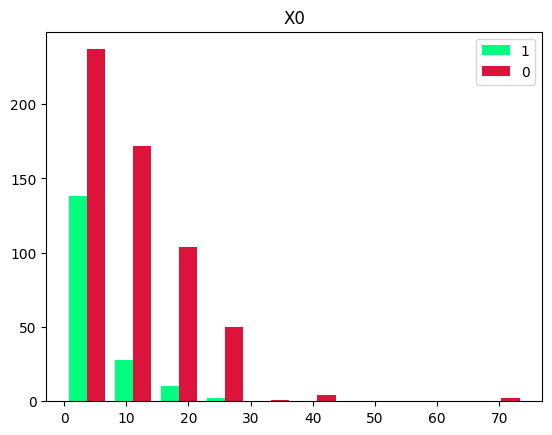

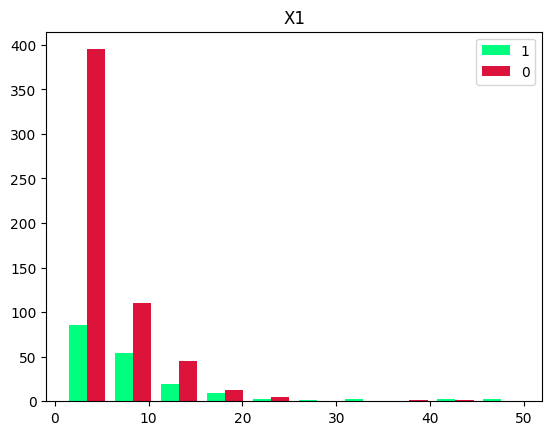

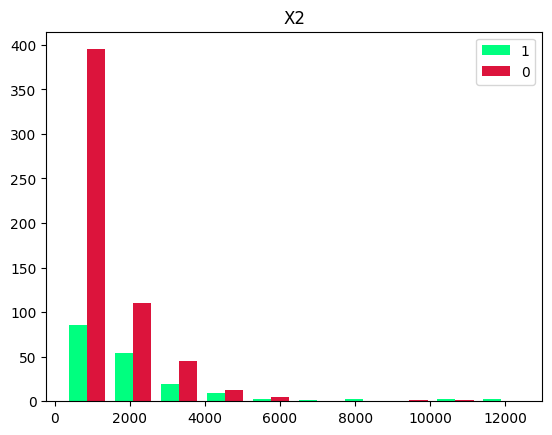

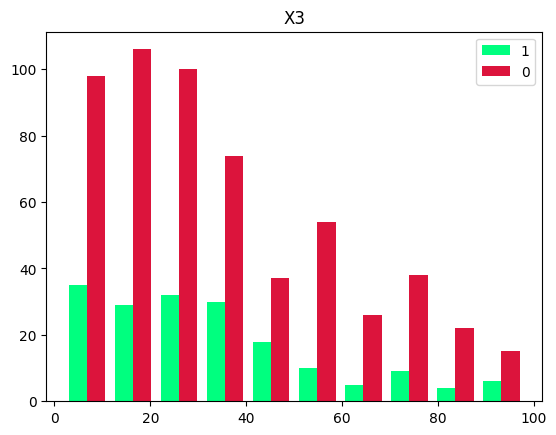

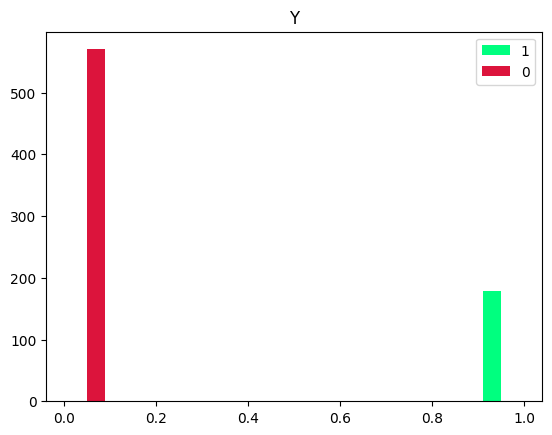

In [26]:
def distClases(data, etiquetas = ['1', '0'], colores=['springgreen', 'crimson']):
    print(f"Distribución de clases en la variable de salida: \n{data['Y'].value_counts()}")
    
    for column in data:  # Visualizamos la distribución de variables por clases
        plt.title(column)
        clases = [data[data['Y'] == eval(i)][column] for i in etiquetas]
        plt.hist(clases, label=etiquetas, color=colores)
        plt.legend(loc='upper right')
        plt.show()


distClases(dataset)

También podemos visualizar los datos y sus clases por pares de atributos:

Correlación numérica entre las variables: 
          X0        X1        X2        X3         Y
X0  1.000000 -0.182745 -0.182745  0.160618 -0.279869
X1 -0.182745  1.000000  1.000000  0.634940  0.218633
X2 -0.182745  1.000000  1.000000  0.634940  0.218633
X3  0.160618  0.634940  0.634940  1.000000 -0.035854
Y  -0.279869  0.218633  0.218633 -0.035854  1.000000


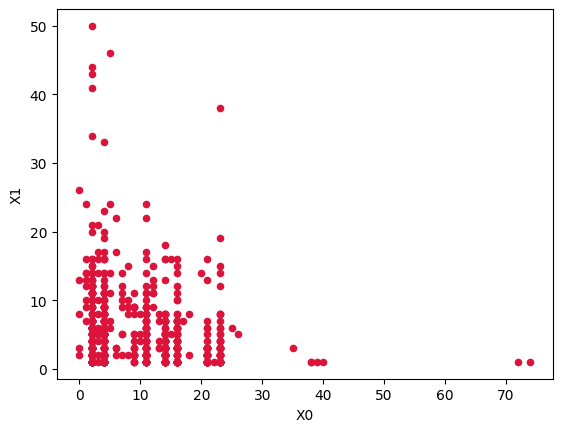

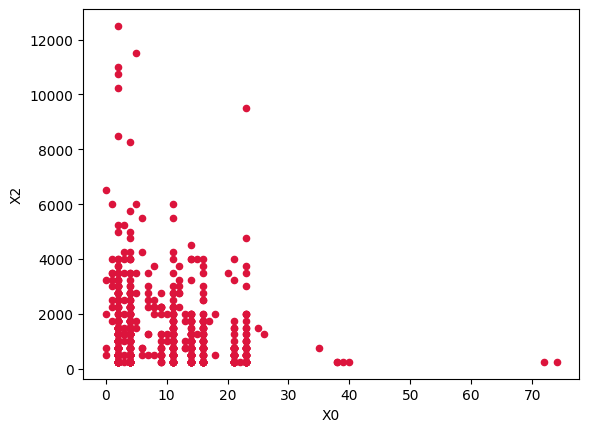

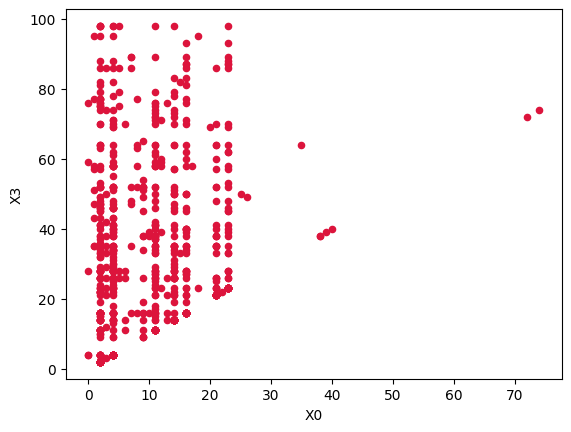

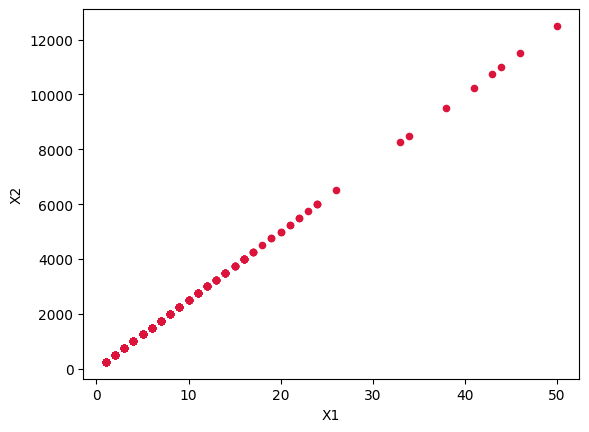

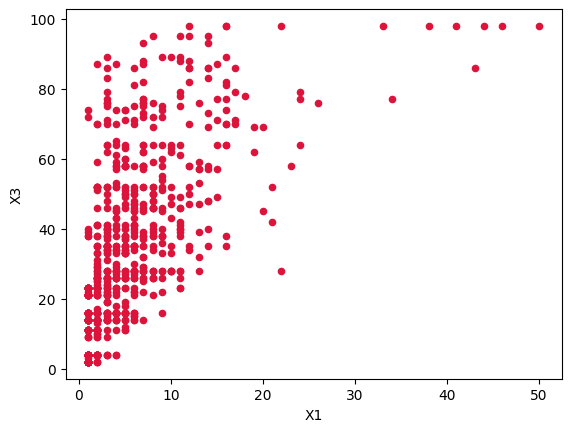

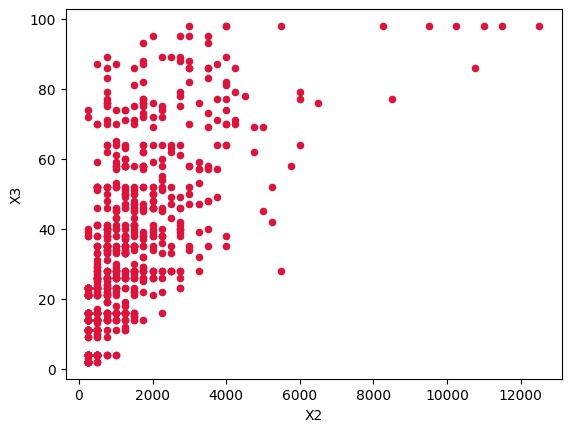

In [27]:
def distPares(data):
    print(f"Correlación numérica entre las variables: \n{data.corr()}") # correlación entre las variables

    column_names = data.columns[:-1]  # Omitimos la variable dependiente
    # Ahora representamos atributos por pares (mostrando también la clase)
    column_names = data.columns[:-1]  # Omitimos la variable dependiente
    for i, columna_i in enumerate(column_names):
        for j, columna_j in enumerate(column_names):
            if i < j:
                fig, ax = plt.subplots()
                data.plot.scatter(columna_i, columna_j, c='crimson', ax=ax)

distPares(dataset)

### División de los datos en entrenamiento (80%) y test (20%)

Para la división de datos entre entrenamiento (80%) y test (20%) usamos `train_test_split`.

In [28]:
dataset_train, dataset_test = train_test_split(dataset, test_size=0.2, random_state=SEED_VALUE, stratify=dataset["Y"])
dataset_test

,X0,X1,X2,X3,Y
309,16,3,750,19,0
711,23,6,1500,45,0
343,11,1,250,11,0
462,21,1,250,21,1
646,14,2,500,14,0
...,...,...,...,...,...
315,4,2,500,29,0
473,14,3,750,83,0
661,16,2,500,16,0
362,4,3,750,71,0


**Gestión de valores faltantes**

Como ya vimos en la breve exploración e los datos, nuestro dataset no tiene valores faltantes.
Sin embargo, la sustitución de las variables predictoras por la media se llevaría a cabo de la siguiente manera. `SimpleImputer` convierte nuestros valores a un array NumPy, por lo que sería bueno que se vuelven a convertir a formato dataframe.

In [29]:
def valoresFaltantes(trainData, testData, mis_val=np.nan, fill_val='mean'):
    imp = SimpleImputer(missing_values=mis_val, fill_value=fill_val) # definimos el mapa
    imp = imp.fit(trainData)  # La media la calculamos SÓLO a partir del conjunto de train 

    # Los valores van a ser los mismos que antes, pues no tenemos datos faltantes
    dataset_train_prep = imp.transform(trainData) # aqui modificamos los datos de train
    dataset_test_prep = imp.transform(testData) # aqui modificamos los datos de test (se usa la media de entrenamiento)

    dataset_train = pd.DataFrame(dataset_train_prep, 
                                 columns=trainData.columns, 
                                 index=trainData.index)
    dataset_test = pd.DataFrame(dataset_test_prep, 
                                columns=testData.columns, 
                                index=testData.index)

    return dataset_train, dataset_test

dataset_train, dataset_test = valoresFaltantes(dataset_train, dataset_test)
dataset_test

,X0,X1,X2,X3,Y
309,16.0,3.0,750.0,19.0,0.0
711,23.0,6.0,1500.0,45.0,0.0
343,11.0,1.0,250.0,11.0,0.0
462,21.0,1.0,250.0,21.0,1.0
646,14.0,2.0,500.0,14.0,0.0
...,...,...,...,...,...
315,4.0,2.0,500.0,29.0,0.0
473,14.0,3.0,750.0,83.0,0.0
661,16.0,2.0,500.0,16.0,0.0
362,4.0,3.0,750.0,71.0,0.0


### Separación de variables predictoras y dependientes y estandarización de los datos

Es recomendable hacer siempre la estandarización de los datos. Esto hay que hacerlo **DESPUÉS** de dividir en conjuntos de entrenamiento y test. En los problemas de clasificación, **NO** estandarizaremos la variable dependiente, pero esto sí es necesario en problemas de regresión.

Definimos una función que, dada los datos de entrenamiento y *test*, separa las varibles predictoras y dependientes (especificadas en los parámetros `preds` y `dep`), y estandariza las variables predictoras o las predictoras y las dependientes (el parámetro `escalar = [True, True]` controla el escalado de las variables: el primer elemento indica si se estandarizan las variables predictoras o no (en este último caso da error, ya que es necesario), y el segundo elemento hace lo mismo con las variables dependientes). 

In [31]:
def splitScale(trainData, testData, preds = ['X0', 'X1', 'X2', 'X3'], dep = 'Y', escalar = [True, True]):

    dataset_train_X = trainData.loc[:, preds[0]:preds[-1]].astype(float)
    dataset_train_Y = trainData.loc[:, dep].astype(float)

    dataset_test_X = testData.loc[:, preds[0]:preds[-1]].astype(float)
    dataset_test_Y = testData.loc[:, dep].astype(float)

    if escalar[0]:
        scalerX = StandardScaler() # creamos el scaler
        scalerX.fit(dataset_train_X) # ajustamos a los datos de TRAIN

        dataset_train_X_scaled = scalerX.transform(dataset_train_X)
        dataset_test_X_scaled = scalerX.transform(dataset_test_X)

        print("Valores con los que se ha estandarizado:\n")
        
        statsPreds = pd.DataFrame([scalerX.mean_, scalerX.scale_], 
                                  index = ['Mean', 'std'], 
                                  columns = preds)
        print(f"{statsPreds}\n")

        if escalar[1]:
            
            dataset_train_Y = dataset_train_Y.to_frame()
            dataset_test_Y = dataset_test_Y.to_frame()
            
            scalerY = StandardScaler()
            scalerY.fit(dataset_train_Y) # ajustamos a los datos de TRAIN

            dataset_train_Y_scaled = scalerY.transform(dataset_train_Y)
            dataset_test_Y_scaled = scalerY.transform(dataset_test_Y)

            statsDep = pd.DataFrame([scalerY.mean_, scalerY.scale_], 
                                    index = ['Mean', 'std'], 
                                    columns = [dep])
            print(statsDep)

            return dataset_train_X_scaled, dataset_train_Y_scaled, dataset_test_X_scaled, dataset_test_Y_scaled, [scalerX, scalerY]
        
        return dataset_train_X_scaled, dataset_train_Y, dataset_test_X_scaled, dataset_test_Y, scalerX
    
    else: 
        raise ValueError("Es necesario escalar los predictores")

In [32]:
dataset_train_X_scaled, dataset_train_Y, dataset_test_X_scaled, dataset_test_Y, scalerX = splitScale(dataset_train, dataset_test, preds = ['X0', 'X1', 'X2', 'X3'], dep = 'Y', escalar=[True, False])

Valores con los que se ha estandarizado:

            X0        X1           X2         X3
Mean  9.508361  5.637124  1409.280936  34.879599
std   7.893041  5.893176  1473.294031  24.729957



### Exploración de hiperparámetros

Hemos visualizado y preprocesado los datos. Vamos a empezar a trabajar con nuestro predictor. Importante conocer los hiperparámetros del modelo a usar. Debemos sobreaprender y subaprender. Primero hacemos exploracion de hiperparámetros de grano grueso y luego de grano fino.

`GridSearch` admite una gran variedad de modelos, por lo que definir una función que lo aplique resultará de utilidad. Pasando el modelo a usar el *grid* de hiperparámetros, obtenemos los resultados de los modelos explorados. Además, como lo usaremos con frecuencia, añadimos una columna a los resultados calculando el error medio. 

In [33]:
def crossVal(trainDataX, trainDataY, modelo, hiperparametros, cv = 5, scoring = 'accuracy'):
    modelCV = GridSearchCV(modelo, 
                           param_grid = hiperparametros, # grid de hiperparametros
                           cv = cv, # conjuntos de validacion cruzada (folds)
                           scoring = scoring, # metrica de evaluacion 
                           return_train_score = True)
    
    np.random.seed(SEED_VALUE) 
    modelCV.fit(trainDataX, trainDataY)
    resultados = pd.DataFrame(modelCV.cv_results_)
    
    if scoring == 'accuracy': 
        resultados['mean_test_error'] = 1 - resultados.loc[:, 'mean_test_score']

    return modelCV, resultados

**Regla de una desviación estándar**

Definimos también una función para aplicar el método de una desviación estándar sobre nuestros resultados. Esta función devuelve un DataFrame con los modelos cuyo error se aleja en, como mucho, una desviación estándar del modelo con un error mínimo, así como el valor numérico de esta cota (error mínimo más su desviación estándar).

In [34]:
def onestdRule(resultados, hyp='param_min_samples_split', classification = True):
    best_model = resultados[resultados['rank_test_score'] == 1]
    
    if len(best_model) > 1:
        mejor = best_model[hyp].max()
        best_model = best_model[best_model[hyp] == mejor]

    if classification:
        cota_std = best_model['mean_test_error'].item() + best_model['std_test_score'].item()
        modelos_menores = resultados[resultados['mean_test_error'] <= cota_std]
    
    else: 
        cota_std = best_model['mean_test_score'].item() + best_model['std_test_score'].item()
        modelos_menores = resultados[resultados['mean_test_score'] <= cota_std]

    return modelos_menores, cota_std

**Exploración de grano grueso**

En esta práctica, el único parámetro a explorar es el tamaño mínimo de hoja. Hacemos primero una exploración de valores en un rango amplio (gg), para subaprender y sobreaprender. De este modo, luego seleccionaremos un rango más limitado de este parámetro y podremos explorar todas las posibilidades en el mismo.

In [35]:
hyperparameters_gg = {'min_samples_split': range(2, 300, 5)}
tree_gg = DecisionTreeClassifier(criterion='entropy')

modeloCV_gg, cv_results_gg = crossVal(dataset_train_X_scaled, dataset_train_Y, tree_gg, hyperparameters_gg)
modeloCV_gg

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(criterion='entropy'),
             param_grid={'min_samples_split': range(2, 300, 5)},
             return_train_score=True, scoring='accuracy')

Como también queremos encontrar el mejor modelo en caso de aplicar la regla de una desviación estándar, calcularemos esta cota para ver visualmente el rango que habrá que explorar luego en mayor detalle.

In [36]:
_, cota_std_gg = onestdRule(cv_results_gg, hyp='param_min_samples_split')

**Gráfica de entrenamiento (primera aproximación)**

Aqui deberiamos tener una grafica más o menos convexa para ver que ahi esta el minimo. Hacemos una función que grafique el error frente al hiperparámetro explorado. Además, se incorpora la posibilidad de representar una cota fijada por el error mínimo más una desviación estándar, para aplicar visualemente el método de una desviación estándar. 

In [37]:
def errorVal(resultados, hiperparams_name, ax, label = 'uniform', color = 'crimson', cota_std = None, classification = True):
    ejex = resultados[hiperparams_name]
    if classification:
        ejey = 1 - resultados['mean_test_score']
    
    else: 
        ejey = resultados['mean_test_score']

    errory = resultados['std_test_score']

    ax.errorbar(ejex, ejey, yerr = errory, label = label, color = color, capsize = 3)
    ax.axhline(y = cota_std, linestyle = 'dashed', color = 'springgreen', label = 'one-std') if cota_std else None
    ax.set_xlim(min(ejex) - 2, max(ejex) + 2)
    ax.set_ylim(min(ejey) / 1.2, max(ejey) * 1.15)
    ax.grid(axis = 'y', alpha = 0.5)
    ax.legend(loc='upper right')

    return ax

Visualizamos los modelos encontrados en este rango del hiperparametro.

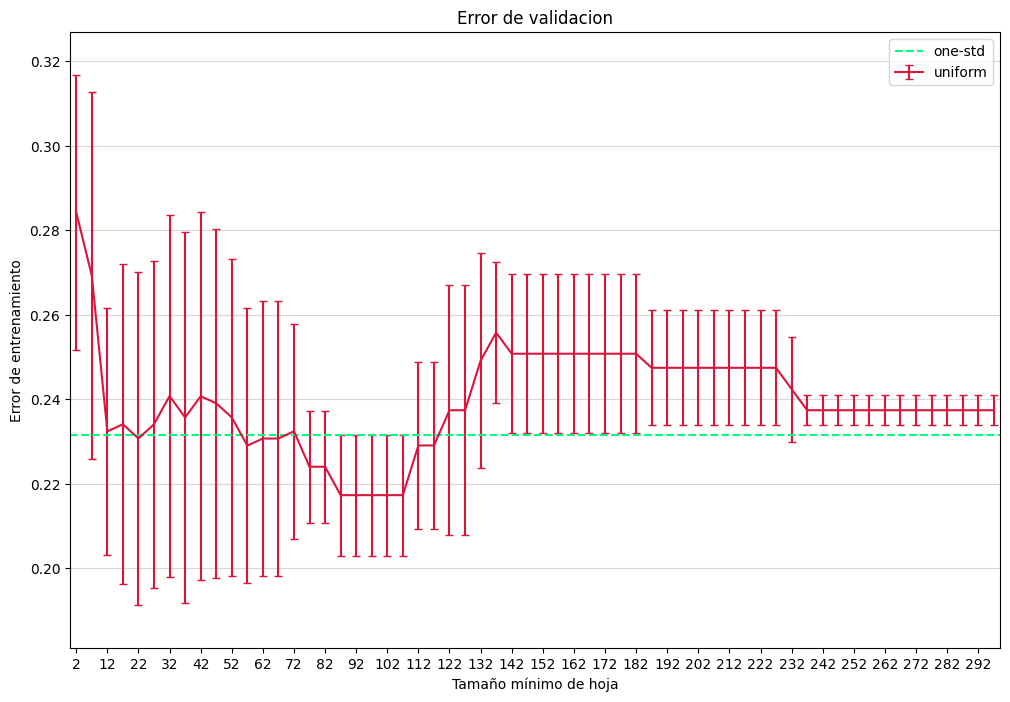

In [38]:
fig_gg, ax_gg = plt.subplots(figsize=(12,8))
ax_gg.set_title("Error de validacion")
ax_gg.set_xlabel("Tamaño mínimo de hoja")
ax_gg.set_ylabel("Error de entrenamiento")
ax_gg.set_xticks(np.arange(2, 300, 10))

errorVal(cv_results_gg, 'param_min_samples_split', ax_gg, cota_std=cota_std_gg)

plt.show()

El mejor modelo está con casi total seguridad entre un tamaño mínimo de $80$ y $110$. Sin embargo, también queremos el mejor modelo según la regla de una desviación estándar. Por ello, debemos recorrer los valores en las proximidades de la línea verde, que fija la cota de la desviación estándar. Barreremos el rango de $[60, 130]$. Incluimos valores ligeramente por encima de la cota ya que, haciendo una exploración en mayor profundidad, puede haber algún modelo en ese rango que entre dentro de la cota.

**Exploración de grano fino**

Repetimos la exploración, esta vez barriendo todos los valores del intervalo. Así encontraremos el modelo con el menor error de validación cruzada para este problema.

In [39]:
hyperparameters_gf = {'min_samples_split': range(60, 130, 1)}
tree_gf = DecisionTreeClassifier(criterion='entropy')

modeloCV_gf, cv_results_gf = crossVal(dataset_train_X_scaled, dataset_train_Y, tree_gf, hyperparameters_gf)
modeloCV_gf

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(criterion='entropy'),
             param_grid={'min_samples_split': range(60, 130)},
             return_train_score=True, scoring='accuracy')

Los mejores modelos y sus estadísticas son los siguientes:

In [40]:
cv_results_best_gf = cv_results_gf[cv_results_gf['rank_test_score'] == 1]
cv_results_best_gf.loc[:, ['param_min_samples_split', 'mean_test_score', 'mean_test_error', 'std_test_score', 'rank_test_score']]

,param_min_samples_split,mean_test_score,mean_test_error,std_test_score,rank_test_score
23,83,0.782647,0.217353,0.014349,1
24,84,0.782647,0.217353,0.014349,1
25,85,0.782647,0.217353,0.014349,1
26,86,0.782647,0.217353,0.014349,1
27,87,0.782647,0.217353,0.014349,1
28,88,0.782647,0.217353,0.014349,1
29,89,0.782647,0.217353,0.014349,1
30,90,0.782647,0.217353,0.014349,1
31,91,0.782647,0.217353,0.014349,1
32,92,0.782647,0.217353,0.014349,1


In [44]:
cv_results_una_std_gf = cv_results_gf[cv_results_gf['param_min_samples_split'] == cv_results_best_gf['param_min_samples_split'].max()]
cv_results_una_std_gf.loc[:, ['param_min_samples_split', 'mean_test_score', 'mean_test_error', 'std_test_score', 'rank_test_score']]

,param_min_samples_split,mean_test_score,mean_test_error,std_test_score,rank_test_score
50,110,0.782647,0.217353,0.014349,1


**Regla de una desviacion estandar**

Podemos seleccionar el mejor modelo según la regla de una desviación estándar de forma numérica, así como su hiperparámetro.

In [45]:
modelos_una_std_gf, cota_std_gf = onestdRule(cv_results_gf, hyp='param_min_samples_split')
modelos_una_std_gf.loc[:, ['param_min_samples_split', 'mean_test_score', 'mean_test_error', 'std_test_score', 'rank_test_score']]

,param_min_samples_split,mean_test_score,mean_test_error,std_test_score,rank_test_score
0,60,0.770910,0.229090,0.032514,41
1,61,0.769244,0.230756,0.032475,51
2,62,0.769244,0.230756,0.032475,51
3,63,0.769244,0.230756,0.032475,51
4,64,0.769244,0.230756,0.032475,51
5,65,0.769244,0.230756,0.032475,51
6,66,0.769244,0.230756,0.032475,51
7,67,0.769244,0.230756,0.032475,51
8,68,0.769244,0.230756,0.032475,51
9,69,0.769244,0.230756,0.032475,51


Así, el modelo que habría que seleccionar según esta regla es el siguiente, con un tamaño mínimo de hoja de $119$.

In [46]:
cv_results_una_std_gf = cv_results_gf[cv_results_gf['param_min_samples_split'] == 119]
cv_results_una_std_gf.loc[:, ['param_min_samples_split', 'mean_test_score', 'mean_test_error', 'std_test_score', 'rank_test_score']]

,param_min_samples_split,mean_test_score,mean_test_error,std_test_score,rank_test_score
59,119,0.770882,0.229118,0.019768,42


**Gráfica de entrenamiento**

A continuación mostramos la gráfica del error de entrenamiento con validación cruzada frente al valor del hiperparámetro.

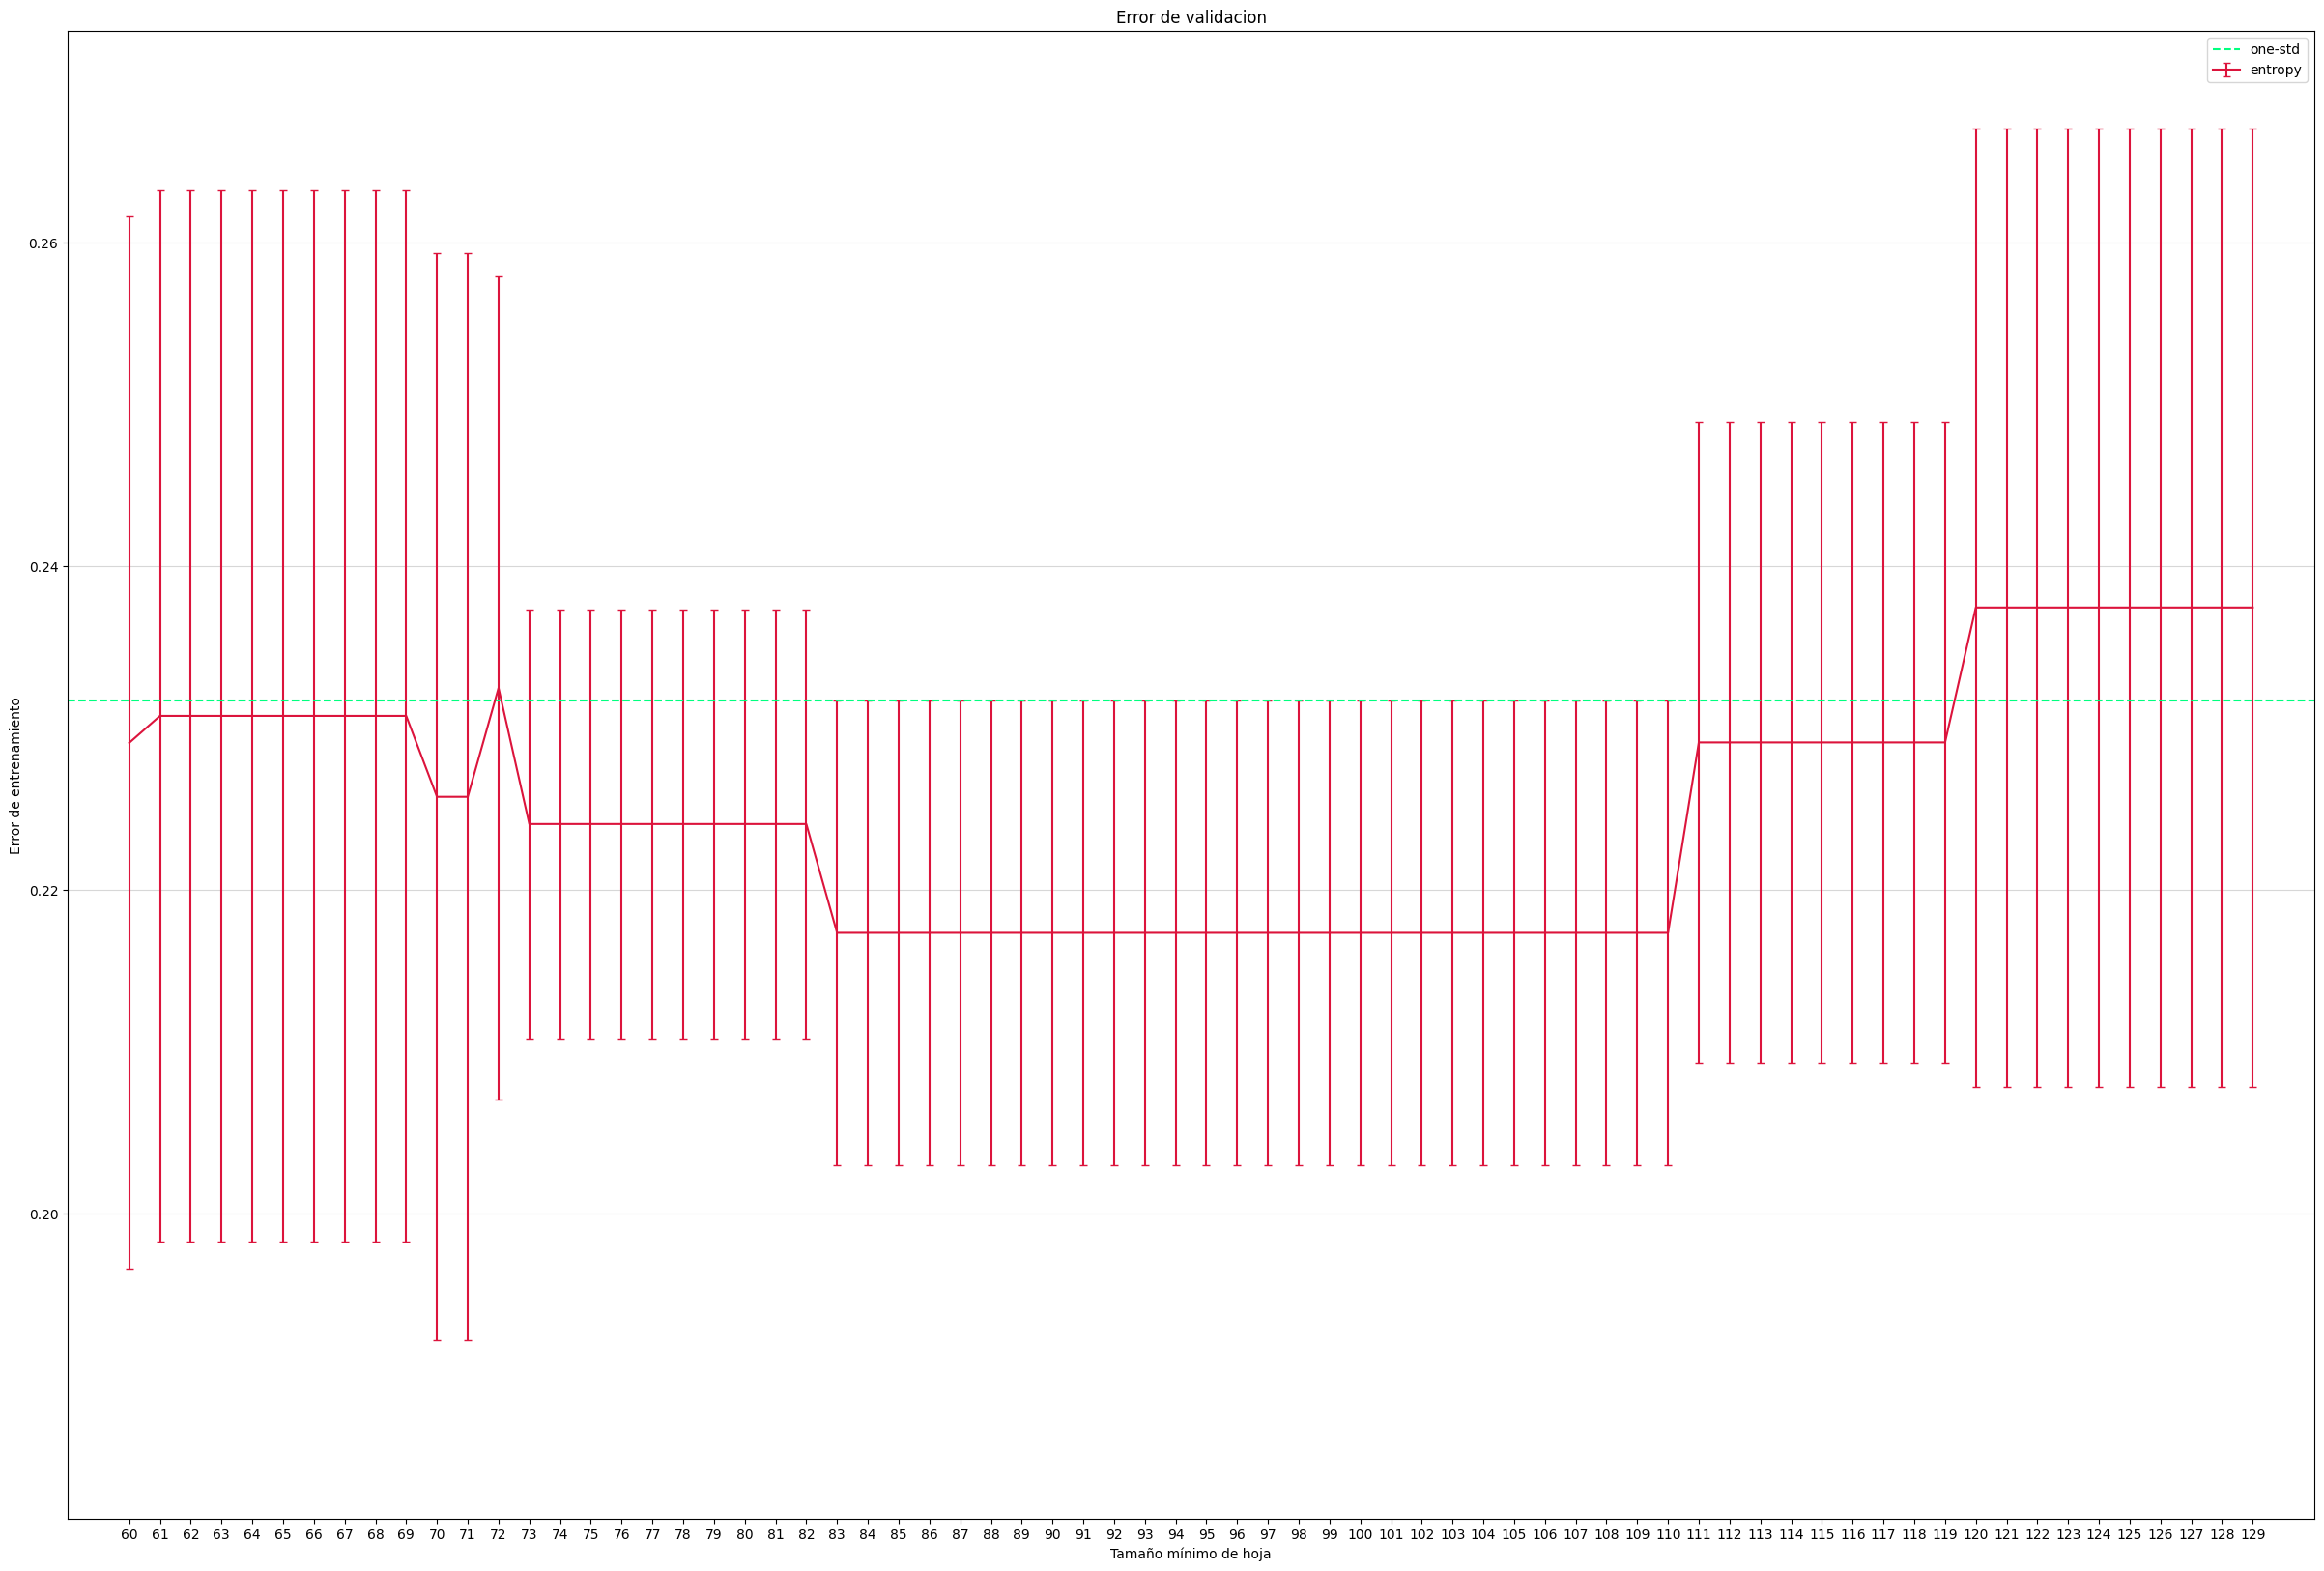

In [47]:
fig_gf, ax_gf = plt.subplots(figsize=(30,20))
ax_gf.set_title("Error de validacion")
ax_gf.set_xlabel("Tamaño mínimo de hoja")
ax_gf.set_ylabel("Error de entrenamiento")
ax_gf.set_xticks(np.arange(60, 130, 1))

errorVal(cv_results_gf, 'param_min_samples_split', ax_gf, cota_std = cota_std_gf, label='entropy')

plt.savefig("ej2_1.pdf", dpi=150)
plt.show()

Aquí podemos ver visualmente los resultados anteriores: el mejor modelo es para un tamaño mínimo de hoja de 110, mientras que el mejor modelo según la regla de una desviación estándar es para 119

### Verificación de hiperparámetros en *test*

Esto no se haría **JAMÁS** en una situación real. Pero como este es un ejemplo para aprender, vamos a ver cómo de lejos nos hemos quedado de los hiperparámetros "ideales". Hacemos un Grid Search utilizando el conjunto de entrenamiento al completo (80% de los datos) y nuestro conjunto de validación va a ser el conjunto de test (20% de los datos).

In [48]:
split_test_fold = [-1]*len(dataset_train_Y) + [0]*len(dataset_test_Y)
ps = PredefinedSplit(test_fold=split_test_fold) # fijamos una particion de datos (forzamos al metodo a que particione como queremos)

# Juntamos los conjuntos de entrenamiento y test, fingiendo que son un sólo conjunto de entrenamiento-validación
dataset_all_X_scaled = np.vstack([dataset_train_X_scaled, dataset_test_X_scaled])
dataset_all_Y = pd.concat([dataset_train_Y, dataset_test_Y])

tree = DecisionTreeClassifier(criterion='entropy')
modeloCV_test, cv_results_test = crossVal(dataset_all_X_scaled, dataset_all_Y, tree, hyperparameters_gf, cv = ps)
modeloCV_test

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=DecisionTreeClassifier(criterion='entropy'),
             param_grid={'min_samples_split': range(60, 130)},
             return_train_score=True, scoring='accuracy')

Ahora mostramos la gráfica del error de *test* frente al valor del hiperparámetro junto con la del error de entrenamiento, lo que permitirá comparar si la gráfica del error de entrenamiento con validación cruzada ha hecho una buena estimación del error de *test*.

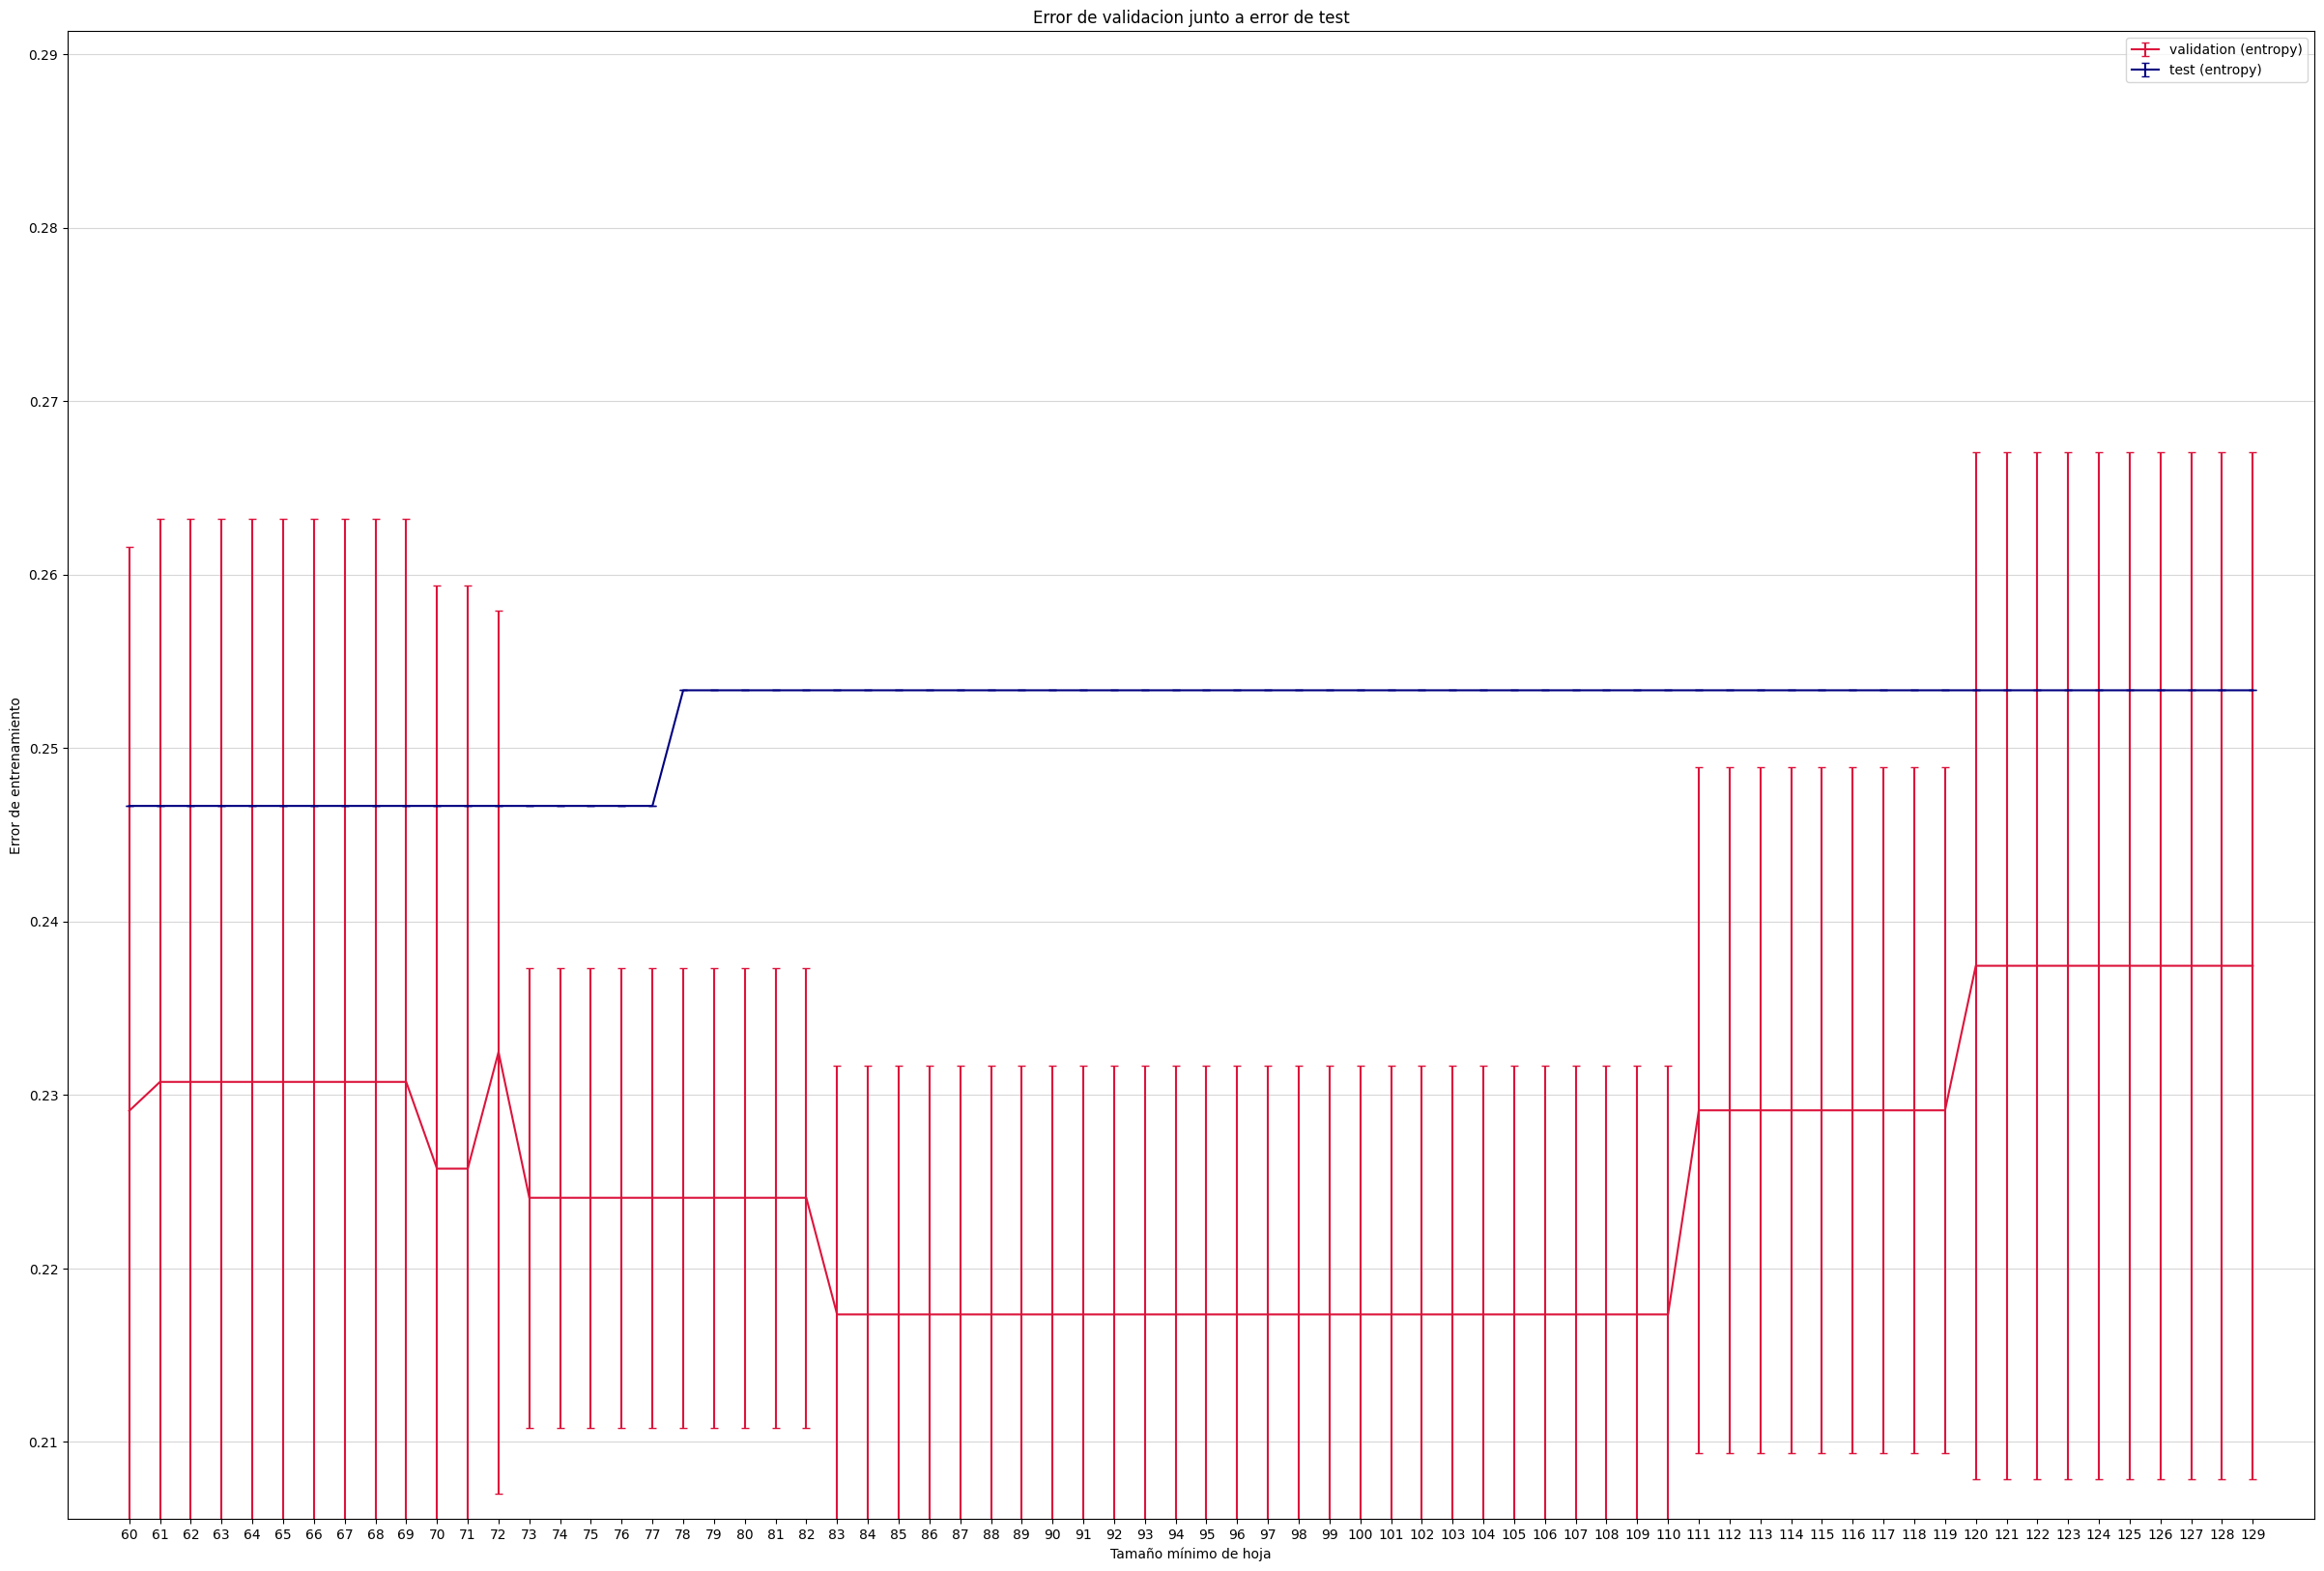

In [51]:
fig_test, ax_test = plt.subplots(figsize=(30, 20))
ax_test.set_title("Error de validacion junto a error de test")
ax_test.set_xlabel("Tamaño mínimo de hoja")
ax_test.set_ylabel("Error de entrenamiento")
ax_test.set_xticks(np.arange(60, 130, 1))

errorVal(cv_results_gf, 'param_min_samples_split', ax_test, label = 'validation (entropy)')
errorVal(cv_results_test, 'param_min_samples_split', ax_test, label = 'test (entropy)', color = 'navy')
plt.savefig("ej2_2.pdf", dpi=150)
plt.show()

El error de *test* para el valor del hiperparámetro seleccionado por la validación cruzada será:

In [53]:
best_cv_results_test = cv_results_test[cv_results_test['param_min_samples_split'] == cv_results_best_gf['param_min_samples_split'].max()]
best_cv_results_test.loc[:, ['param_min_samples_split', 'mean_test_score', 'mean_test_error', 'std_test_score', 'rank_test_score']]

,param_min_samples_split,mean_test_score,mean_test_error,std_test_score,rank_test_score
50,110,0.746667,0.253333,0.0,19


### Evaluación del modelo con datos de *test*

A continuación, usamos los datos de *test* para hacer predicciones. Usamos el `GridSearch` de grano fino.

In [54]:
Z = modeloCV_gf.predict(dataset_test_X_scaled)

Para evaluar las predicciones del modelo, usaremos una matriz de confusión junto con el propio reporte de clasificación. Creamos una función que, dados los valores reales y los predichos, nos da toda la información necesaria

In [55]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def evaluacion(y_true, y_pred):
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}", end='. ')
    print(f"Error: {1 - accuracy_score(y_true, y_pred):.4f}")
    print("\nReporte de clasificación:")
    print(classification_report(y_true, y_pred))
    # Calcular matriz de confusión
    cm = confusion_matrix(y_true, y_pred)

    # Crear visualización
    fig, ax = plt.subplots(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title('Matriz de Confusión')
    ax.set_xlabel('Predicción')
    ax.set_ylabel('Valor Real')
    plt.show()
    return 

Accuracy: 0.7467. Error: 0.2533

Reporte de clasificación:
              precision    recall  f1-score   support

         0.0       0.80      0.89      0.84       114
         1.0       0.46      0.31      0.37        36

    accuracy                           0.75       150
   macro avg       0.63      0.60      0.60       150
weighted avg       0.72      0.75      0.73       150



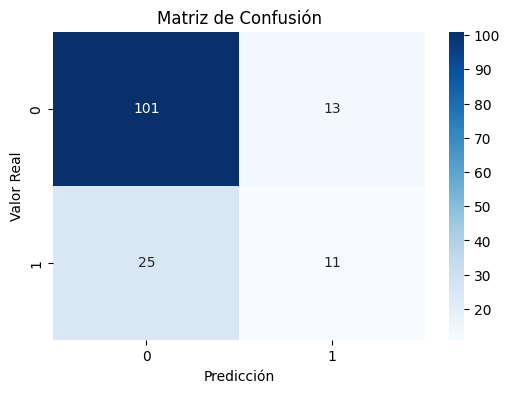

In [56]:
evaluacion(dataset_test_Y, Z)

# Ejercicio 3

**Definición de variables globales**

In [57]:
DATASET_NAME3 = '/Users/luisi/Documents/Master-Big-Data/Aprendizaje estadístico/Práctica/Datos/EnergyEfficiency.data' 

**Lectura del fichero de datos**

In [58]:
dataset3 = pd.read_csv(DATASET_NAME3, 
                      delimiter=DATASET_DELIMITER,
                      skiprows=1, # la primera fila no contiene datos
                      header=None,
                      names = ["X1", "X2", "X3", "X4", "X5", "X6", "X7", "X8", "Y2"])
dataset3

,X1,X2,X3,X4,X5,X6,X7,X8,Y2
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,28.28
...,...,...,...,...,...,...,...,...,...
763,0.64,784.0,343.0,220.50,3.5,5,0.4,5,21.40
764,0.62,808.5,367.5,220.50,3.5,2,0.4,5,16.88
765,0.62,808.5,367.5,220.50,3.5,3,0.4,5,17.11
766,0.62,808.5,367.5,220.50,3.5,4,0.4,5,16.61


**Exploración de los datos**

A continuación, vemos si hay valores perdidos en nuestro conjunto de datos (en caso afirmativo, haremos el tratamiento más adelante). Visualizamos también estadísticas descriptivas de las variables predictoras. 

In [59]:
print(f"Valores faltantes: \n{dataset3.isnull().sum()}\n")
print("Estadísticas de los predictores y la variable dependiente:")
dataset3.describe()

Valores faltantes: 
X1    0
X2    0
X3    0
X4    0
X5    0
X6    0
X7    0
X8    0
Y2    0
dtype: int64

Estadísticas de los predictores y la variable dependiente:


,X1,X2,X3,X4,X5,X6,X7,X8,Y2
count,768.000000,768.000000,768.000000,768.000000,768.00000,768.000000,768.000000,768.00000,768.000000
mean,0.764167,671.708333,318.500000,176.604167,5.25000,3.500000,0.234375,2.81250,24.587760
std,0.105777,88.086116,43.626481,45.165950,1.75114,1.118763,0.133221,1.55096,9.513306
min,0.620000,514.500000,245.000000,110.250000,3.50000,2.000000,0.000000,0.00000,10.900000
25%,0.682500,606.375000,294.000000,140.875000,3.50000,2.750000,0.100000,1.75000,15.620000
50%,0.750000,673.750000,318.500000,183.750000,5.25000,3.500000,0.250000,3.00000,22.080000
75%,0.830000,741.125000,343.000000,220.500000,7.00000,4.250000,0.400000,4.00000,33.132500
max,0.980000,808.500000,416.500000,220.500000,7.00000,5.000000,0.400000,5.00000,48.030000


El fichero contiene 9 variables y 748 observaciones distintas. Las variables predictoras son `X1`, `X2`, `X3`, `X4`, `X5`, `X6`, `X7`, `X8`, y la variable dependiente sería `Y2`. Estamos ante un problema de regresión, dada la naturaleza continua de `Y2`.

**Visualización de los datos**

Muchas variables, si bien cuantitativas, solo discretas, por lo que esperamos gran superposición de los puntos al representar las relaciones por pares.

Correlación numérica entre las variables: 
              X1            X2            X3            X4            X5  \
X1  1.000000e+00 -9.919015e-01 -2.037817e-01 -8.688234e-01  8.277473e-01   
X2 -9.919015e-01  1.000000e+00  1.955016e-01  8.807195e-01 -8.581477e-01   
X3 -2.037817e-01  1.955016e-01  1.000000e+00 -2.923165e-01  2.809757e-01   
X4 -8.688234e-01  8.807195e-01 -2.923165e-01  1.000000e+00 -9.725122e-01   
X5  8.277473e-01 -8.581477e-01  2.809757e-01 -9.725122e-01  1.000000e+00   
X6  5.878473e-17 -3.066832e-17 -2.510469e-17 -5.591507e-17  4.876676e-17   
X7 -2.096261e-15  3.623317e-15 -8.647953e-17 -1.753224e-15 -1.977685e-16   
X8 -1.896390e-16  2.441409e-15  2.077332e-16 -1.068485e-15 -9.524163e-17   
Y2  6.343391e-01 -6.729989e-01  4.271170e-01 -8.625466e-01  8.957852e-01   

              X6            X7            X8        Y2  
X1  5.878473e-17 -2.096261e-15 -1.896390e-16  0.634339  
X2 -3.066832e-17  3.623317e-15  2.441409e-15 -0.672999  
X3 -2.510469e-17 -8.64795

/var/folders/cx/qn6km0h17314hbjnc7y0wdy40000gn/T/ipykernel_4650/887047971.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


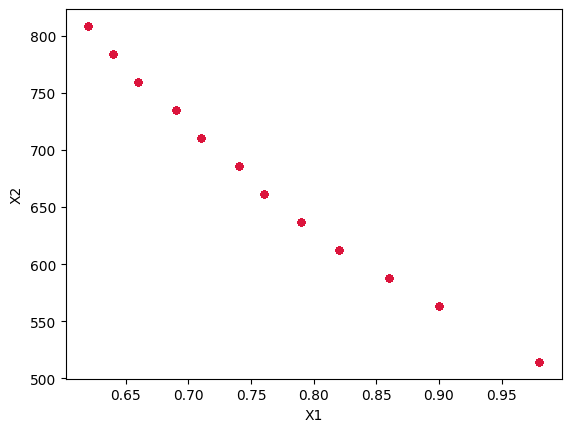

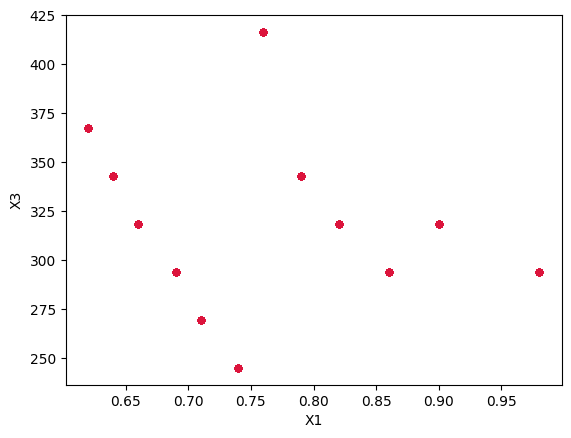

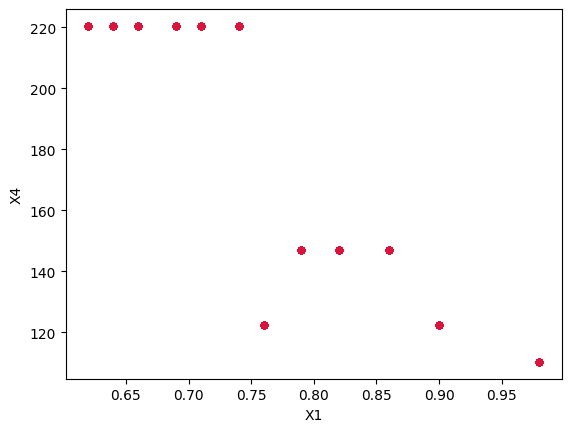

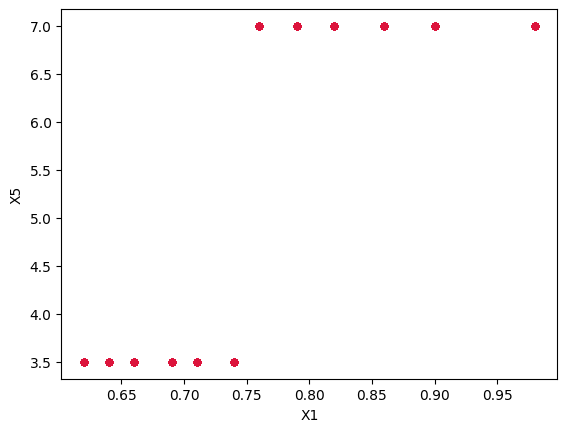

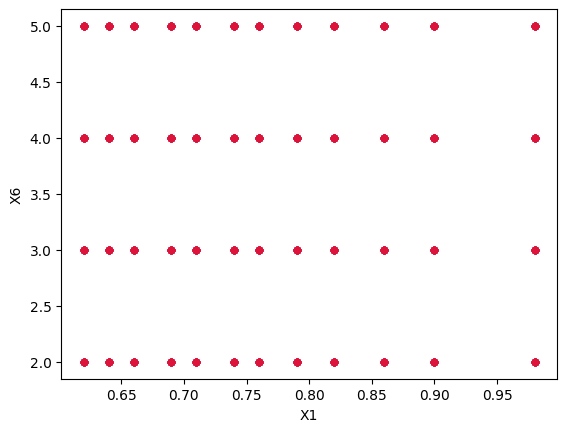

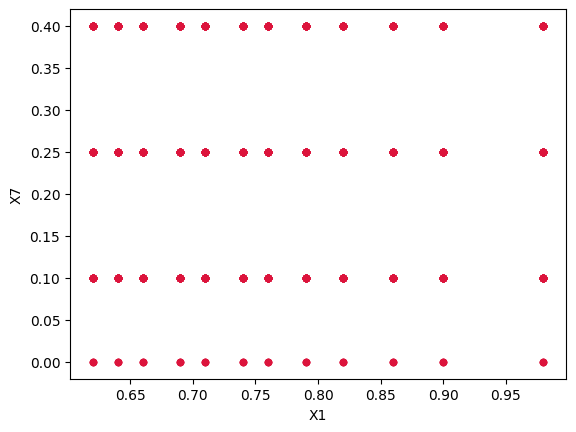

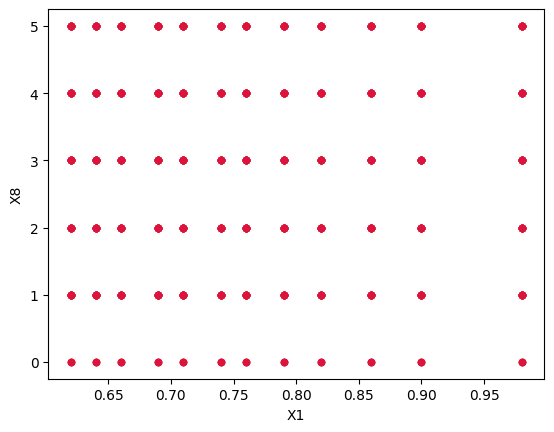

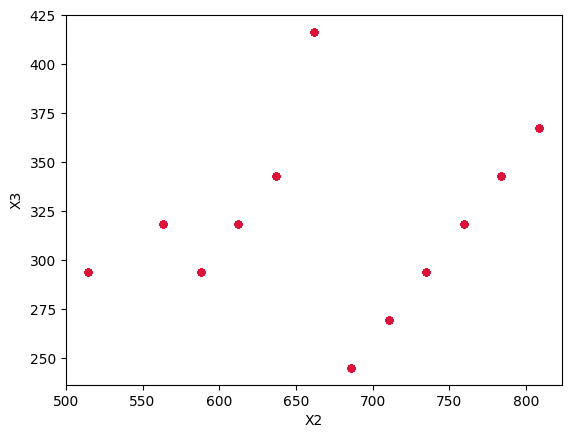

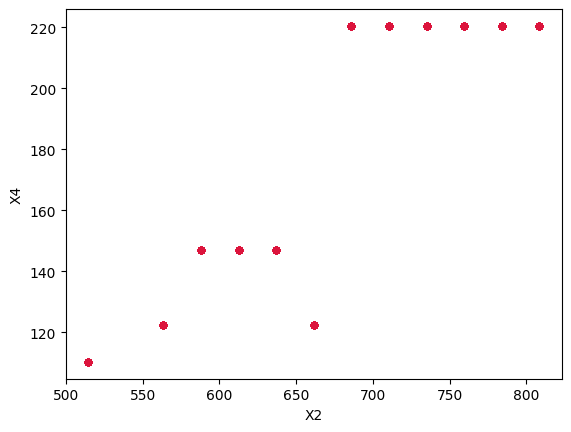

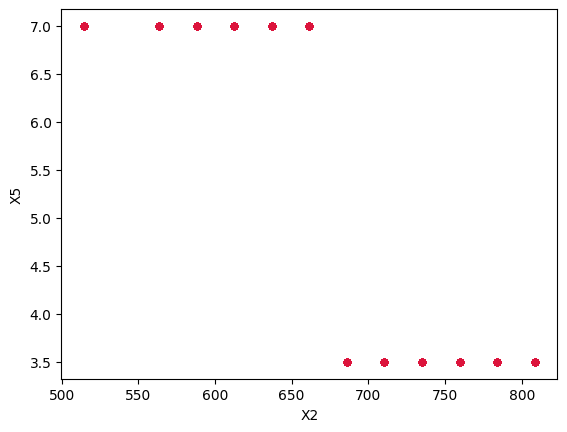

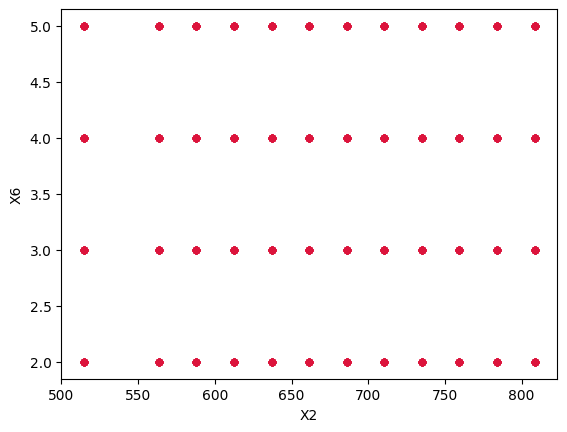

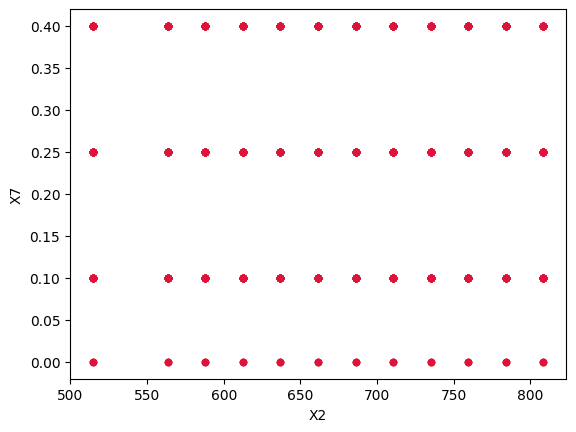

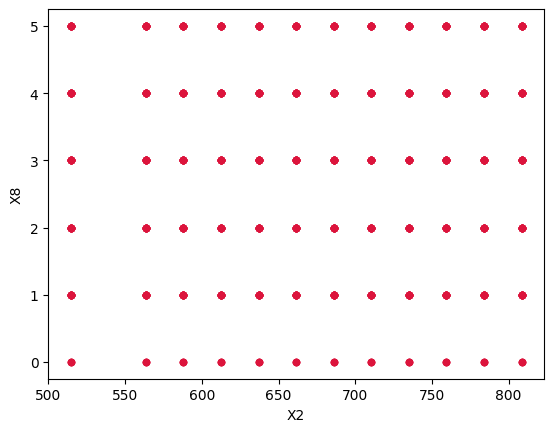

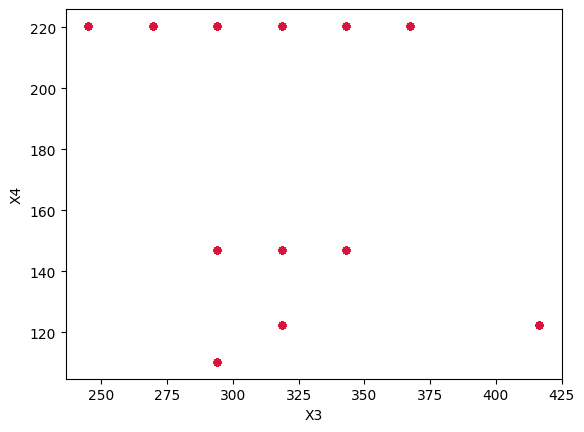

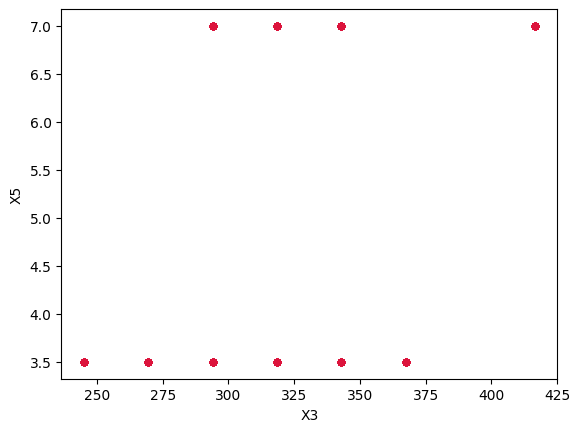

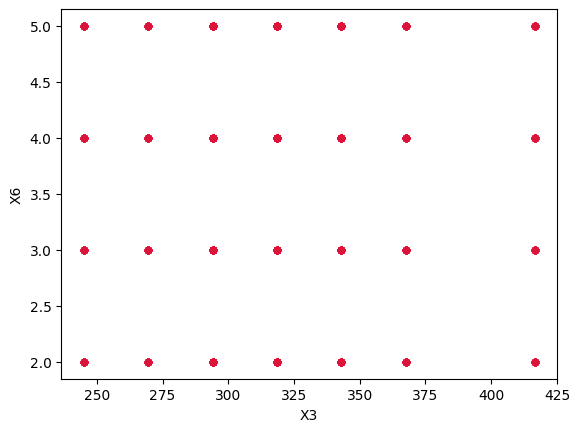

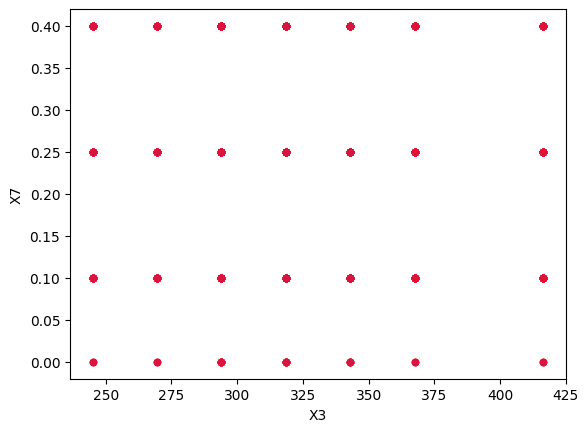

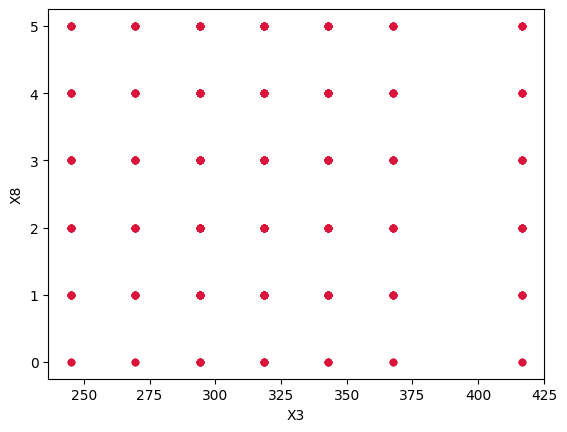

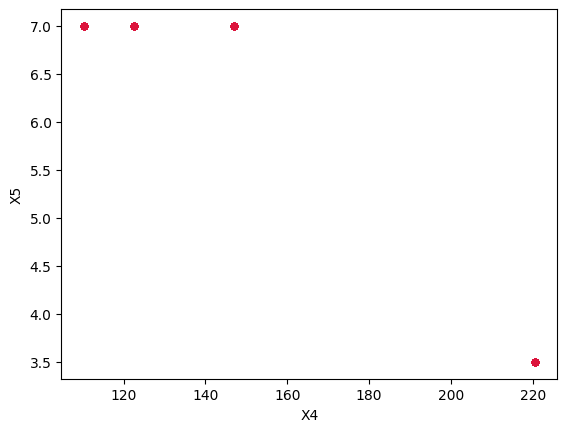

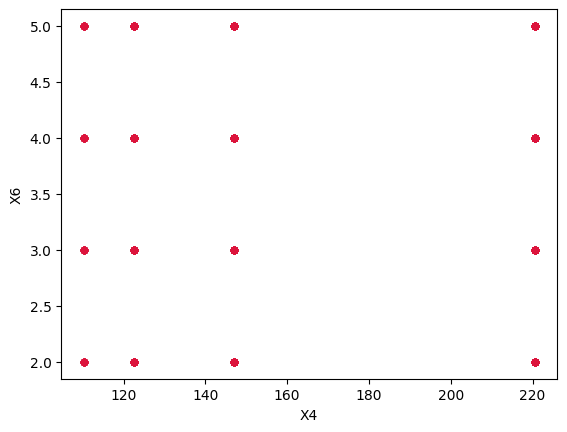

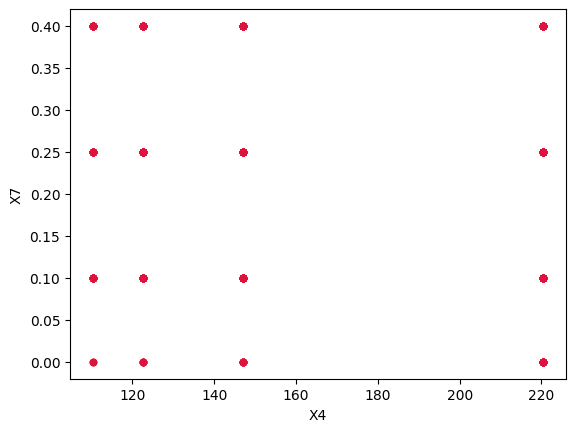

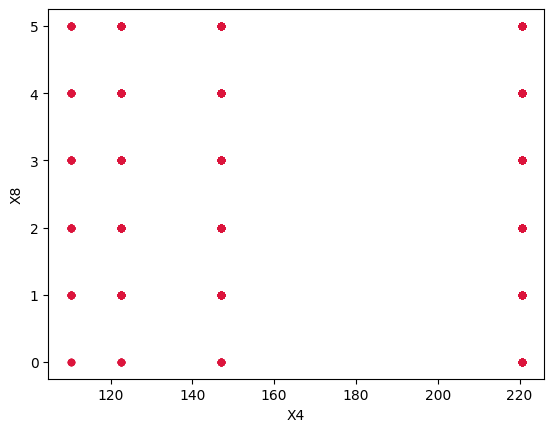

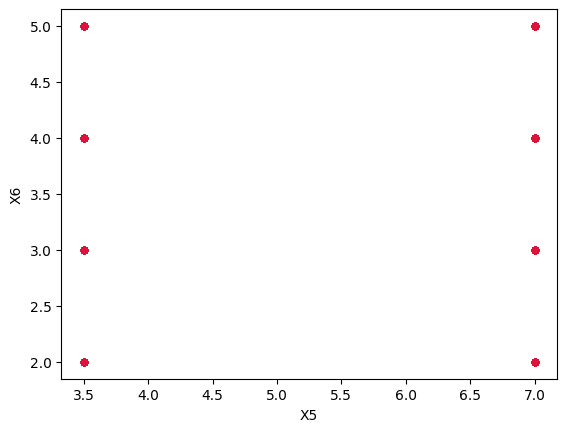

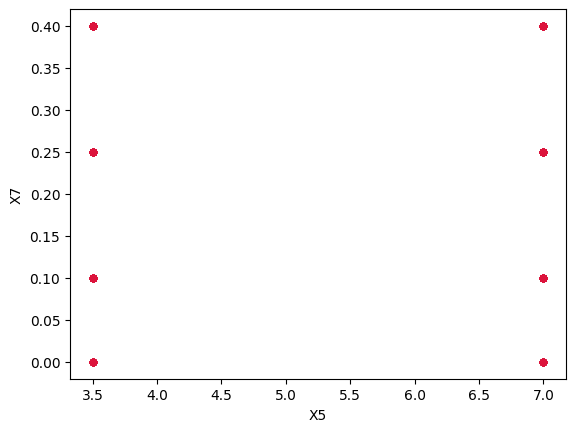

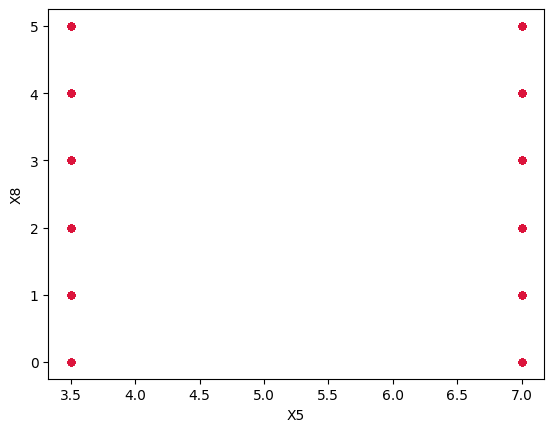

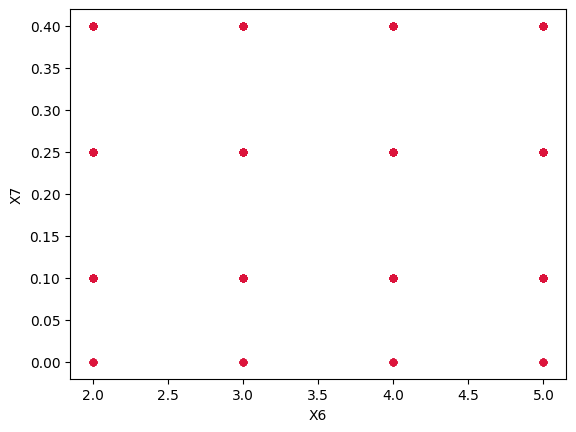

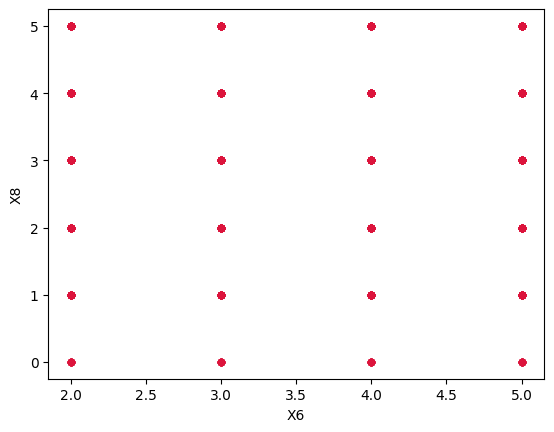

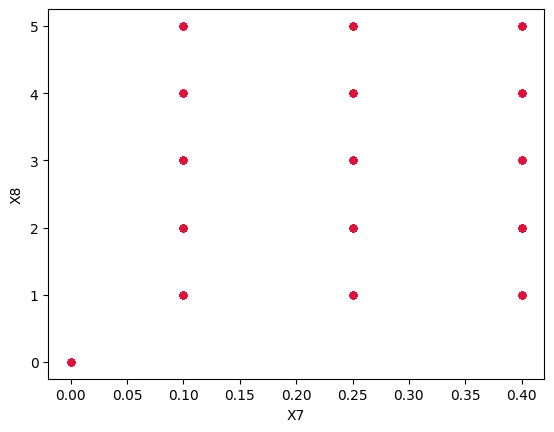

In [60]:
distPares(dataset3)

### División de los datos en entrenamiento (80%) y test (20%)

Para la división de datos entre entrenamiento (80%) y test (20%) usamos `train_test_split`.

In [61]:
dataset_train3, dataset_test3 = train_test_split(dataset3, test_size=0.2, random_state=SEED_VALUE)
dataset_test3

,X1,X2,X3,X4,X5,X6,X7,X8,Y2
285,0.62,808.5,367.5,220.5,3.5,3,0.10,5,13.97
101,0.90,563.5,318.5,122.5,7.0,3,0.10,2,29.44
581,0.90,563.5,318.5,122.5,7.0,3,0.40,2,35.39
352,0.79,637.0,343.0,147.0,7.0,2,0.25,2,43.86
726,0.90,563.5,318.5,122.5,7.0,4,0.40,5,38.79
...,...,...,...,...,...,...,...,...,...
563,0.69,735.0,294.0,220.5,3.5,5,0.40,1,17.20
318,0.71,710.5,269.5,220.5,3.5,4,0.25,1,15.44
154,0.86,588.0,294.0,147.0,7.0,4,0.10,3,25.90
684,0.82,612.5,318.5,147.0,7.0,2,0.40,4,28.20


**Gestión de valores faltantes**

Como ya vimos en la breve exploración e los datos, nuestro dataset no tiene valores faltantes.

In [62]:
dataset_train3, dataset_test3 = valoresFaltantes(dataset_train3, dataset_test3)
dataset_test3

,X1,X2,X3,X4,X5,X6,X7,X8,Y2
285,0.62,808.5,367.5,220.5,3.5,3.0,0.10,5.0,13.97
101,0.90,563.5,318.5,122.5,7.0,3.0,0.10,2.0,29.44
581,0.90,563.5,318.5,122.5,7.0,3.0,0.40,2.0,35.39
352,0.79,637.0,343.0,147.0,7.0,2.0,0.25,2.0,43.86
726,0.90,563.5,318.5,122.5,7.0,4.0,0.40,5.0,38.79
...,...,...,...,...,...,...,...,...,...
563,0.69,735.0,294.0,220.5,3.5,5.0,0.40,1.0,17.20
318,0.71,710.5,269.5,220.5,3.5,4.0,0.25,1.0,15.44
154,0.86,588.0,294.0,147.0,7.0,4.0,0.10,3.0,25.90
684,0.82,612.5,318.5,147.0,7.0,2.0,0.40,4.0,28.20


### Separación de variables predictoras y dependientes y estandarización de los datos

Como ahora estamos en un problema de regresión, es necesario estandarizar también la variable dependiente.

In [63]:
dataset_train_X_scaled3, dataset_train_Y_scaled3, dataset_test_X_scaled3, dataset_test_Y_scaled3, scaler3 = splitScale(dataset_train3, dataset_test3, preds = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8'], dep = 'Y2', escalar=[True, True])

Valores con los que se ha estandarizado:

            X1          X2          X3          X4        X5        X6  \
Mean  0.762769  673.191368  318.140879  177.525244  5.198697  3.473941   
std   0.106922   88.806099   43.961322   45.464442  1.749248  1.119186   

            X7        X8  
Mean  0.231922  2.838762  
std   0.132407  1.542576  

             Y2
Mean  24.324870
std    9.453206


### Exploración de hiperparámetros

Hemos visualizado y preprocesado los datos. Vamos a empezar a trabajar con nuestro predictor. Importante conocer los hiperparámetros del modelo a usar. Debemos sobreaprender y subaprender. Primero hacemos exploracion de hiperparámetros de grano grueso y luego de grano fino.

**Exploración de grano grueso**

En esta práctica, el único parámetro a explorar es el tamaño mínimo de hoja. Hacemos primero una exploración de valores en un rango amplio (gg), para subaprender y sobreaprender. De este modo, luego seleccionaremos un rango más limitado de este parámetro y podremos explorar todas las posibilidades en el mismo. Esta vez, el `scoring` será el MSE, aunque `scikit-learn` implementa el -MSE, por lo que deberemos cambiarle el signo

In [66]:
hyperparameters_gg3 = {'min_samples_split': range(2, 300, 10)}
tree_gg = DecisionTreeRegressor(criterion='squared_error') # mse en version antigua, square error en version nueva

modeloCV_gg3, cv_results_gg3 = crossVal(dataset_train_X_scaled3, dataset_train_Y_scaled3, 
                                        tree_gg, hyperparameters_gg3, 
                                        scoring = 'neg_mean_squared_error')
modeloCV_gg3

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid={'min_samples_split': range(2, 300, 10)},
             return_train_score=True, scoring='neg_mean_squared_error')

Es importante tener en cuenta que, al estandarizar la variable dependiente, hay que desestandarizar los campos 'mean_test_score' y 'std_test_score', sin más que multiplicarlo por la varianza de las observaciones de Y del conjunto de entrenamiento. Esta información la tenemos guardada en el `scaler` de estas observaciones. 

Como también queremos encontrar el mejor modelo en caso de aplicar la regla de una desviación estándar, calcularemos esta cota para ver visualmente el rango que habrá que explorar luego en mayor detalle.

In [67]:
_, scalerY3 = scaler3
std_Y_reg = scalerY3.scale_ 
cv_results_gg3['mean_test_score'] = -cv_results_gg3['mean_test_score'] * (std_Y_reg.item())**2
cv_results_gg3['std_test_score'] = cv_results_gg3['std_test_score'] * (std_Y_reg.item())**2

In [68]:
_, cota_std_gg3 = onestdRule(cv_results_gg3, hyp = 'param_min_samples_split', classification = False)

Visualizamos los modelos encontrados en este rango de tamaño mínimo de hoja. 

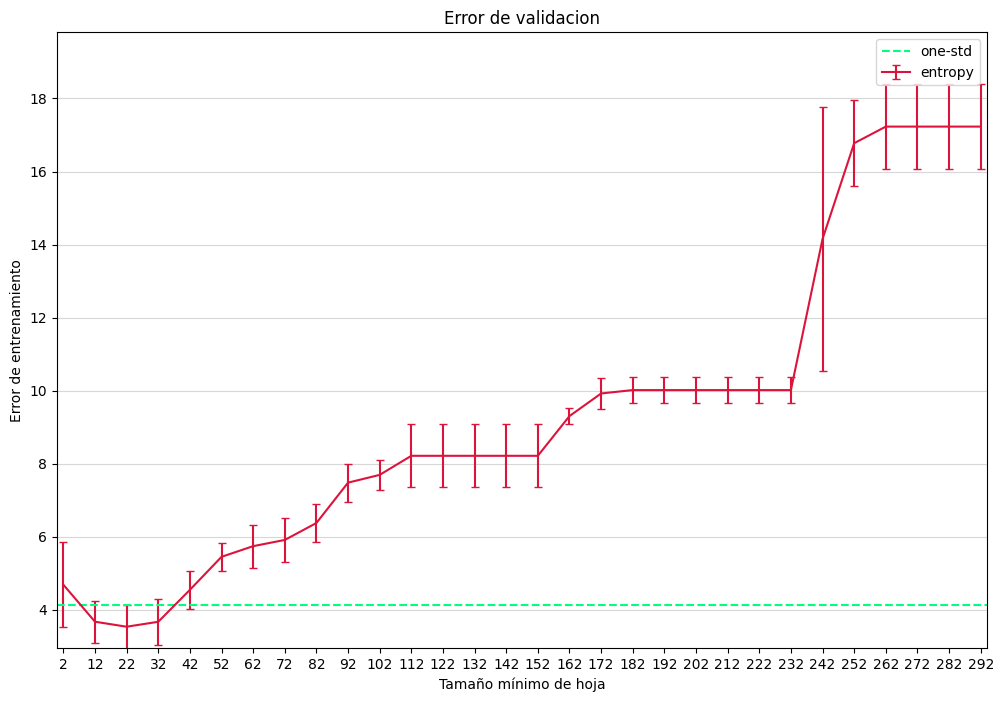

In [69]:
fig_gg3, ax_gg3 = plt.subplots(figsize=(12,8))
ax_gg3.set_title("Error de validacion")
ax_gg3.set_xlabel("Tamaño mínimo de hoja")
ax_gg3.set_ylabel("Error de entrenamiento")
ax_gg3.set_xticks(np.arange(2, 300, 10))

errorVal(cv_results_gg3, 'param_min_samples_split', ax_gg3, cota_std=cota_std_gg3, label='entropy', classification = False)

#ax_gg3.set_ylim(6.5, 13)

plt.savefig("ej3_1.pdf", dpi=150)

plt.show()

El mejor modelo está con casi total seguridad entre un tamaño mínimo de $12$ y $32$. Sin embargo, también queremos el mejor modelo según la regla de una desviación estándar. Barreremos el rango de $[2, 42]$.

**Exploración de grano fino**

Repetimos la exploración, esta vez barriendo todos los valores en ese intervalo. Así encontraremos el modelo con el menor error de validación cruzada para este problema.

In [71]:
hyperparameters_gf3 = {'min_samples_split': range(2, 42, 1)}
tree_gf3 = DecisionTreeRegressor(criterion='squared_error') # mse en version antigua, square error en version nueva

modeloCV_gf3, cv_results_gf3 = crossVal(dataset_train_X_scaled3, dataset_train_Y_scaled3, 
                                        tree_gf3, hyperparameters_gf3, 
                                        scoring = 'neg_mean_squared_error')
modeloCV_gf3

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid={'min_samples_split': range(2, 42)},
             return_train_score=True, scoring='neg_mean_squared_error')

Desestadarizamos el error y la desviación estándar del mismo modo que antes

In [72]:
cv_results_gf3['mean_test_score'] = -cv_results_gf3['mean_test_score'] * (std_Y_reg.item())**2
cv_results_gf3['std_test_score'] = cv_results_gf3['std_test_score'] * (std_Y_reg.item())**2

Los mejores hiperparámetros en validación cruzada serían los siguientes:

In [86]:
cv_results_best_gf3 = cv_results_gf3[cv_results_gf3['rank_test_score'] == 1]
cv_results_best_gf3.loc[:, ['param_min_samples_split', 'mean_test_score', 'std_test_score', 'rank_test_score']]

,param_min_samples_split,mean_test_score,std_test_score,rank_test_score
13,15,3.400035,0.68836,1


**Regla de una desviacion estandar**

Podemos seleccionar el mejor modelo según la regla de una desviación estándar de forma numérica, así como su hiperparámetro.

In [87]:
modelos_una_std_gf3, cota_std_gf3 = onestdRule(cv_results_gf3, hyp = 'param_min_samples_split', classification = False)
modelos_una_std_gf3.loc[:, ['param_min_samples_split', 'mean_test_score', 'std_test_score', 'rank_test_score']]

,param_min_samples_split,mean_test_score,std_test_score,rank_test_score
8,10,4.041511,0.651140,26
9,11,3.696796,0.637991,22
10,12,3.670935,0.574995,20
11,13,3.540002,0.660456,6
12,14,3.517948,0.658958,2
13,15,3.400035,0.688360,1
14,16,3.601390,0.588233,14
15,17,3.677685,0.642317,21
16,18,3.608691,0.557408,15
17,19,3.548382,0.567428,8


Así, el modelo que habría que seleccionar según esta regla es de nuevo el mejor. 

In [88]:
cv_results_una_std_gf3 = cv_results_gf3[cv_results_gf3['param_min_samples_split'] == 35]
cv_results_una_std_gf3.loc[:, ['param_min_samples_split', 'mean_test_score', 'std_test_score', 'rank_test_score']]

,param_min_samples_split,mean_test_score,std_test_score,rank_test_score
33,35,4.024361,0.449845,25


**Gráfica de entrenamiento**

A continuación mostramos la gráfica del error de entrenamiento con validación cruzada frente al valor del hiperparámetro.

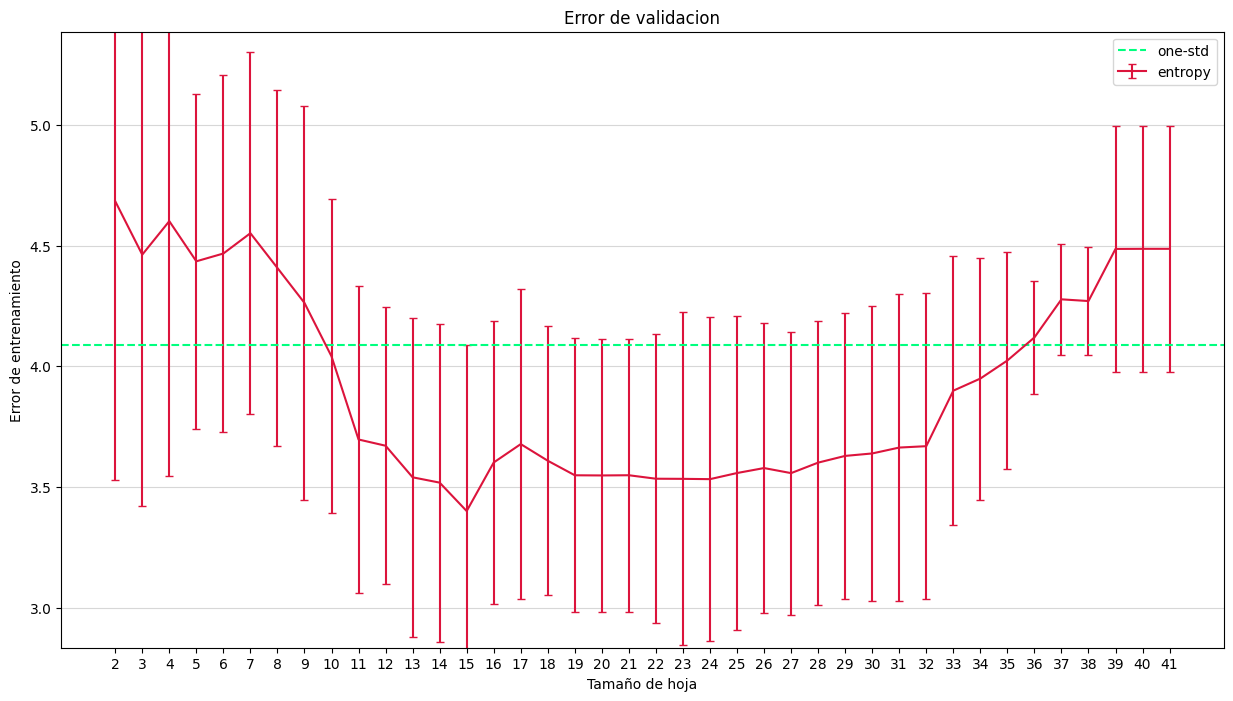

In [89]:
fig_gf3, ax_gf3 = plt.subplots(figsize=(15,8))
ax_gf3.set_title("Error de validacion")
ax_gf3.set_xlabel("Tamaño de hoja")
ax_gf3.set_ylabel("Error de entrenamiento")
ax_gf3.set_xticks(np.arange(2, 42, 1))

errorVal(cv_results_gf3, 'param_min_samples_split', ax_gf3, cota_std = cota_std_gf3, label = 'entropy', classification = False)

#ax_gf3.set_xlim(0, 21)
#ax_gf3.set_ylim(1.055, 1.12)

plt.savefig("ej3_2.pdf", dpi=150)

plt.show()

Aquí podemos ver visualmente los resultados anteriores: el mejor modelo es para un tamaño mínimo de hoja de $15$, mientras que el mejor modelo según la regla de una desviación estándar es para $35$.

### Verificación de hiperparámetros en *test*

Esto no se haría **JAMÁS** en una situación real. Pero como este es un ejemplo para aprender, vamos a ver cómo de lejos nos hemos quedado de los hiperparámetros "ideales". Hacemos un Grid Search utilizando el conjunto de entrenamiento al completo (80% de los datos) y nuestro conjunto de validación va a ser el conjunto de test (20% de los datos).

In [90]:
split_test_fold3 = [-1]*len(dataset_train_Y_scaled3) + [0]*len(dataset_test_Y_scaled3)
ps3 = PredefinedSplit(test_fold=split_test_fold3) # fijamos una particion de datos (forzamos al metodo a que particione como queremos)

# Juntamos los conjuntos de entrenamiento y test, fingiendo que son un sólo conjunto de entrenamiento-validación
dataset_all_X_scaled3 = np.vstack([dataset_train_X_scaled3, dataset_test_X_scaled3])
dataset_all_Y3 = np.vstack([dataset_train_Y_scaled3, dataset_test_Y_scaled3])

tree3 = DecisionTreeRegressor(criterion='squared_error') # mse en version antigua, square error en version nueva
modeloCV_test3, cv_results_test3 = crossVal(dataset_all_X_scaled3, dataset_all_Y3, 
                                            tree3, hyperparameters_gf3, 
                                            cv = ps3, scoring = 'neg_mean_squared_error')
modeloCV_test3

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=DecisionTreeRegressor(),
             param_grid={'min_samples_split': range(2, 42)},
             return_train_score=True, scoring='neg_mean_squared_error')

Desestandarizamos el error y la desviación estándar

In [91]:
cv_results_test3['mean_test_score'] = -cv_results_test3['mean_test_score'] * (std_Y_reg.item())**2
cv_results_test3['std_test_score'] = cv_results_test3['std_test_score'] * (std_Y_reg.item())**2

Ahora mostramos la gráfica del error de *test* frente al valor del hiperparámetro junto con la del error de entrenamiento, lo que permitirá comparar si la gráfica del error de entrenamiento con validación cruzada ha hecho una buena estimación del error de *test*.

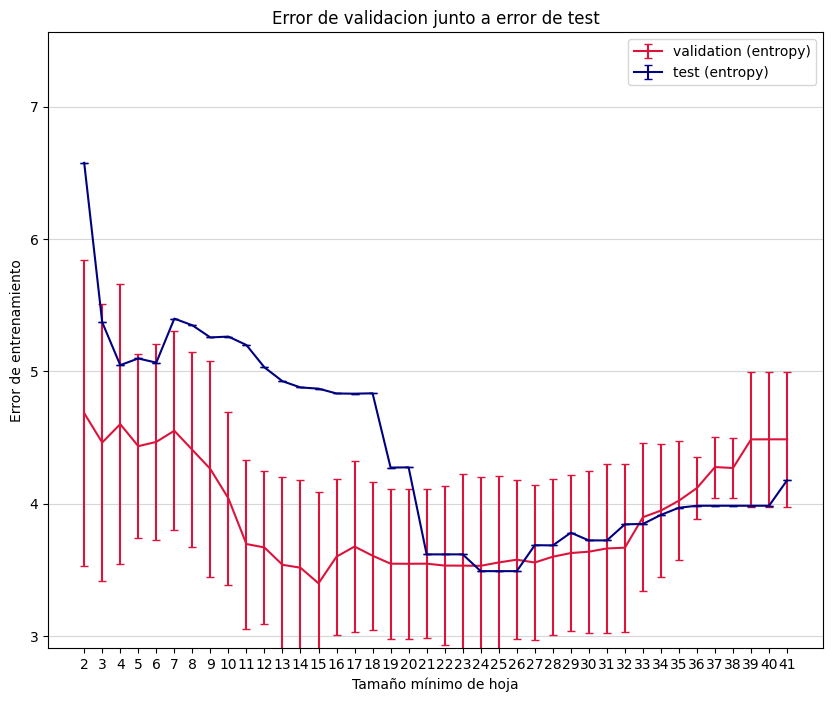

In [92]:
fig_test3, ax_test3 = plt.subplots(figsize=(10, 8))
ax_test3.set_title("Error de validacion junto a error de test")
ax_test3.set_xlabel("Tamaño mínimo de hoja")
ax_test3.set_ylabel("Error de entrenamiento")
ax_test3.set_xticks(np.arange(2, 42, 1))

errorVal(cv_results_gf3, 'param_min_samples_split', ax_test3, label = 'validation (entropy)', classification = False)
errorVal(cv_results_test3, 'param_min_samples_split', ax_test3, label = 'test (entropy)', color = 'navy', classification = False)

#ax_test3.set_xlim(0, 21)
#ax_test3.set_ylim(5, 16)

plt.savefig("ej3_3.pdf", dpi=150)
plt.show()

El error de *test* para el valor del hiperparámetro seleccionado por la validación cruzada será:

In [98]:
best_cv_results_test3 = cv_results_test3[cv_results_test3['param_min_samples_split'] == cv_results_best_gf3['param_min_samples_split'].max()]
best_cv_results_test3.loc[:, ['param_min_samples_split', 'mean_test_score', 'std_test_score', 'rank_test_score']]

,param_min_samples_split,mean_test_score,std_test_score,rank_test_score
13,15,4.87007,0.0,27
